# Overview 

This notebook describes how to run in silico TF perturbations with the GRN models. 
Please read our paper to learn more about the CellOracle algorithm.

### Notebook file
Notebook file is available at CellOracle GitHub.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/05_simulation/Gata1_KO_simulation_with_Paul_etal_2015_data.ipynb

### Data
In this notebook, CellOracle uses two types of input data.

- **Input data 1: Oracle object**. Please look at the previous notebook to learn how to make an `Oracle` object from scRNA-seq. https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

 In this tutorial, we will use the mouse hematopoiesis demo data (Paul et al., 2015). We can load the demo `Oracle` object using the command below.

 `oracle = co.data.load_tutorial_oracle_object()`


- **Input data 2: Links object**. The `Links` oobject stores the GRN data used in the simulations. In this tutorial, we use demo GRNs calculated from the hematopoiesis scRNA-seq data above and one of the mouse sci-ATAC-seq atlas base GRNs. We can load the demo `Links` object with this command.

 `links = co.data.load_tutorial_links_object()`

### What you can do
In this notebook, we perform two analyses.

1. **in silico TF perturbation** to simulate cell identity shifts. CellOracle uses the GRN model to simulate cell identity shifts in response to TF perturbations. For this analysis, you will need the GRN models from the previous notebook.

2. **Compare simulation vectors with developmental vectors**.  In order to properly interpret the simulation results, it is also important to consider the natural direction of development. First, we will calculate a pseudotime gradient vector field to recapitulate the developmental flow. Then, we will compare the CellOracle TF perturbation vector field with the developmental vector field by calculating the inner product scores. Let's call the inner product value as **perturbation score (PS)**. Please see the **step 5.6** for detail.
 
### Custom data class / object

In this notebook, CellOracle uses four custom classes, `Oracle`, `Links`, `Gradient_calculator`, and `Oracle_development_module`.

- `Oracle` is the main class in the CellOracle package.  It is responsible for most of the calculations during GRN model construction and TF perturbation simulations.

- `Links` is a class to store GRN data. 

- The `Gradient_calculator` calculates  the developmental vector field from the pseudotime results. If you do not have pseudotime data for your trajectory, please see the pseudotime notebook to calculate this information. https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html

- The `Oracle_development_module` integrates the `Oracle` object data and the `Gradient_calculator` object data to analyze how TF perturbation affects on the developmental process. It also has many visualization functions.


# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import networkx as nx

# library for KO
import funcs_ko as fko

%load_ext autoreload
%autoreload 2
%matplotlib inline


This notebook was made with celloracle version 0.10.8.
**Please use celloracle>=0.10.8** Otherwise, you may get an error.

In [2]:
import celloracle as co
co.__version__

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


'0.12.0'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

In [4]:
path = os.getcwd()

# run this notebook from the root of the repository
os.chdir(path)

## 0.1. Make a folder to save graph

In [5]:
# Make folder to save plots
save_folder = "figures_perturb"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for information on initializing an `Oracle` object.

In [6]:
# string with the date of today in format dd_mm_yy
from datetime import date
today = date.today()
d1 = today.strftime("%d_%m_%y")

In [7]:
# Load the tutorial oracle object. 
# oracle = co.data.load_tutorial_oracle_object()

# Load our file
oracle = co.load_hdf5(path+"/Our_data_10_01_24_signatures_FullyConnectedGRN.celloracle.oracle")


## 1.2. Load inferred GRNs

In the previous notebook, we calculated the GRNs. Now, we will use these GRNs for the perturbation simulations. First, we will import the GRNs from the `Links` object.

In [8]:
# Here, we load demo links object for the training purpose.
# links = co.data.load_tutorial_links_object()

# Attention!! Please use the function below when you use your data.
# links = co.load_hdf5(file_path="data/links"+d1+".celloracle.links")
links = co.load_hdf5(file_path=path+"/links10_01_24_signatures_FullyConnectedGRN.celloracle.links")

In [9]:
# Path to the CSV file
csv_path = path+'/data/sc_ge_data/genes_order.csv'  # Update this to your actual file path

# Load the CSV file into a pandas DataFrame
genes_df =pd.read_csv(csv_path, header=None)
# convert genes_df into a list
genes_list = genes_df[0].tolist()
print("info genes_list:", len(genes_list), type(genes_list), genes_list)


info genes_list: 24 <class 'list'> ['Klf4', 'Klf2', 'Esrrb', 'Tfcp2l1', 'Tbx3', 'Stat3', 'Nanog', 'Sox2', 'Nr0b1', 'Zic3', 'Rbpj', 'Utf1', 'Etv4', 'Tcf15', 'Dnmt3a', 'Dnmt3b', 'Lef1', 'Otx2', 'Pou3f1', 'Etv5', 'Gbx2', 'Pou5f1', 'Sall4', 'Tcf7l1']


In [10]:
links.links_dict["2"]

source         target  coef_mean  coef_abs             p      -logp
0         Klf8  1700017B05Rik   0.000510  0.000510  1.881070e-04   3.725595
1       Zfp809  1700017B05Rik  -0.000283  0.000283  3.533600e-04   3.451783
2        Hif1a  1700017B05Rik   0.000323  0.000323  1.101954e-02   1.957837
3         Otx2  1700017B05Rik  -0.000822  0.000822  2.943304e-03   2.531165
4        Esrrb  1700017B05Rik   0.001529  0.001529  2.468461e-09   8.607574
...        ...            ...        ...       ...           ...        ...
262659   Grhl2            Zyx   0.000493  0.000493  3.757218e-02   1.425134
262660   Sall4            Zyx   0.001591  0.001591  1.522041e-06   5.817574
262661   Mybl2            Zyx   0.000376  0.000376  2.322391e-01   0.634065
262662    E2f7            Zyx   0.000182  0.000182  1.308053e-01   0.883375
262663    Tfe3            Zyx   0.001906  0.001906  9.482311e-13  12.023086

[262664 rows x 6 columns]

In [11]:
adjacency_matrix_2 = fko.create_adjacency_matrix(links.links_dict["2"], genes_list)
adjacency_matrix_3 = fko.create_adjacency_matrix(links.links_dict["3"], genes_list)
adjacency_matrix_4 = fko.create_adjacency_matrix(links.links_dict["4"], genes_list)
adjacency_matrix_5 = fko.create_adjacency_matrix(links.links_dict["5"], genes_list)
adjacency_matrix_6 = fko.create_adjacency_matrix(links.links_dict["6"], genes_list)

In [12]:
matrices = [ np.array(adjacency_matrix_2.copy().T), 
             np.array(adjacency_matrix_3.copy().T),
            np.array(adjacency_matrix_4.copy().T),
            np.array(adjacency_matrix_5.copy().T),
            np.array(adjacency_matrix_6.copy().T)]  
global_max = max([np.max(matrix) for matrix in matrices])
global_min = min([np.min(matrix) for matrix in matrices])
global_lim = max(np.abs(global_min), global_max)
global_lim

0.05502929911017418

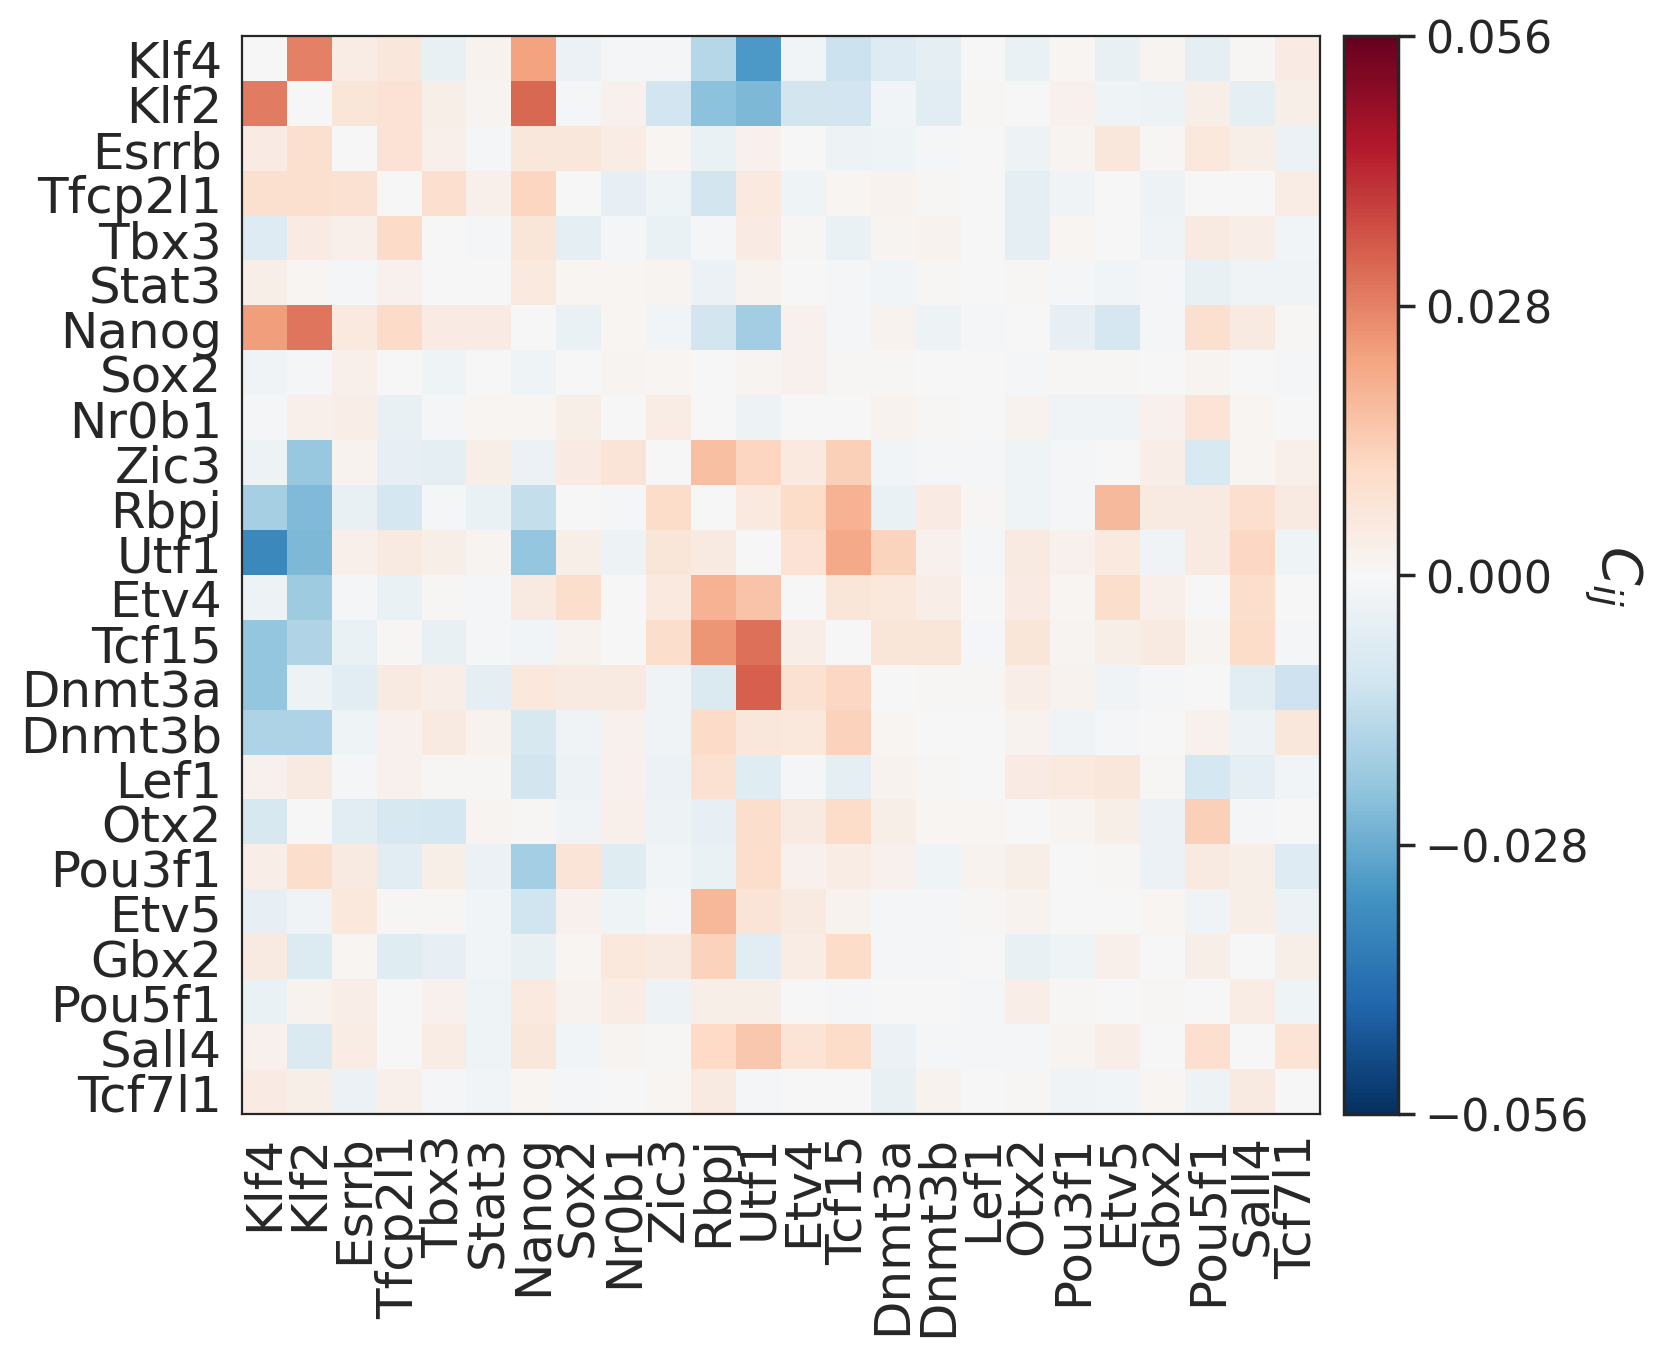

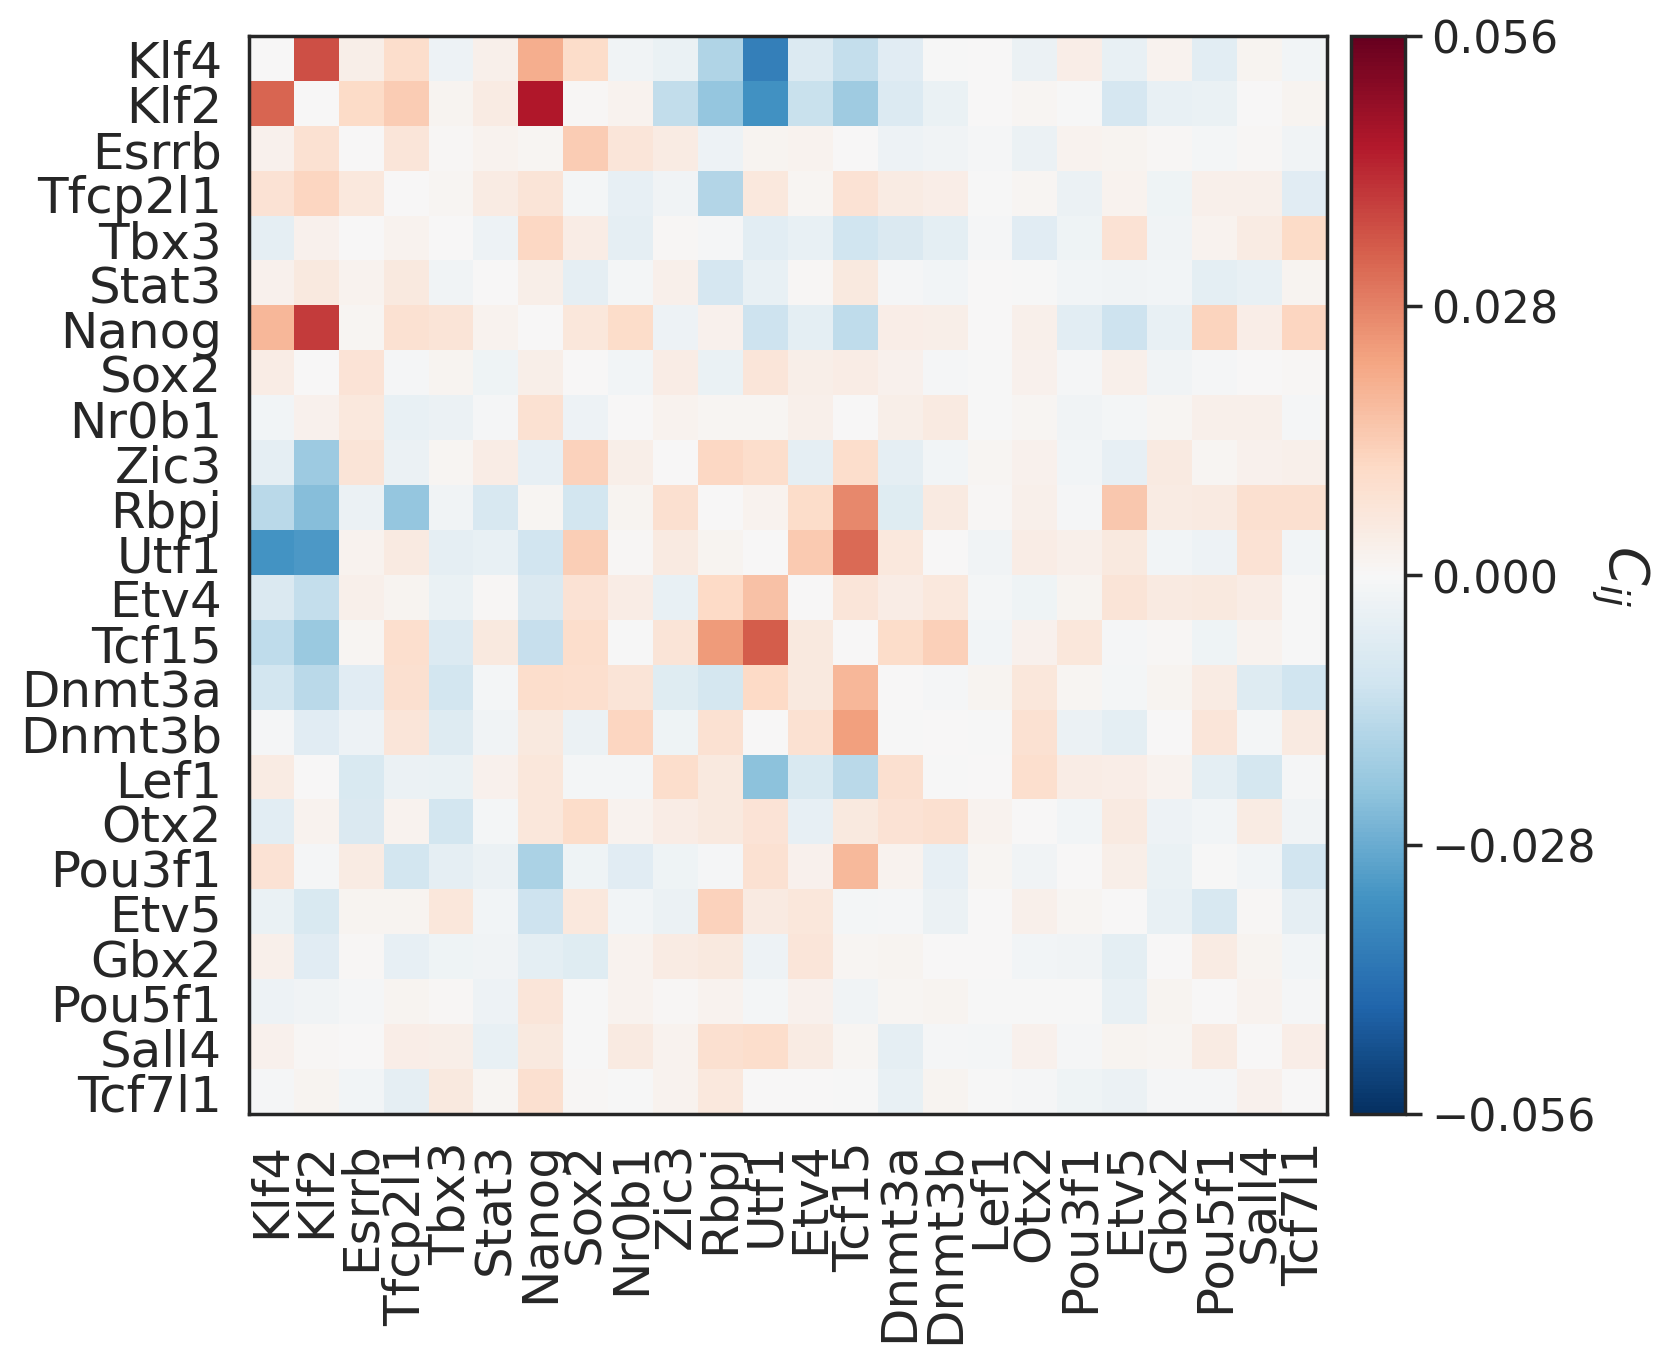

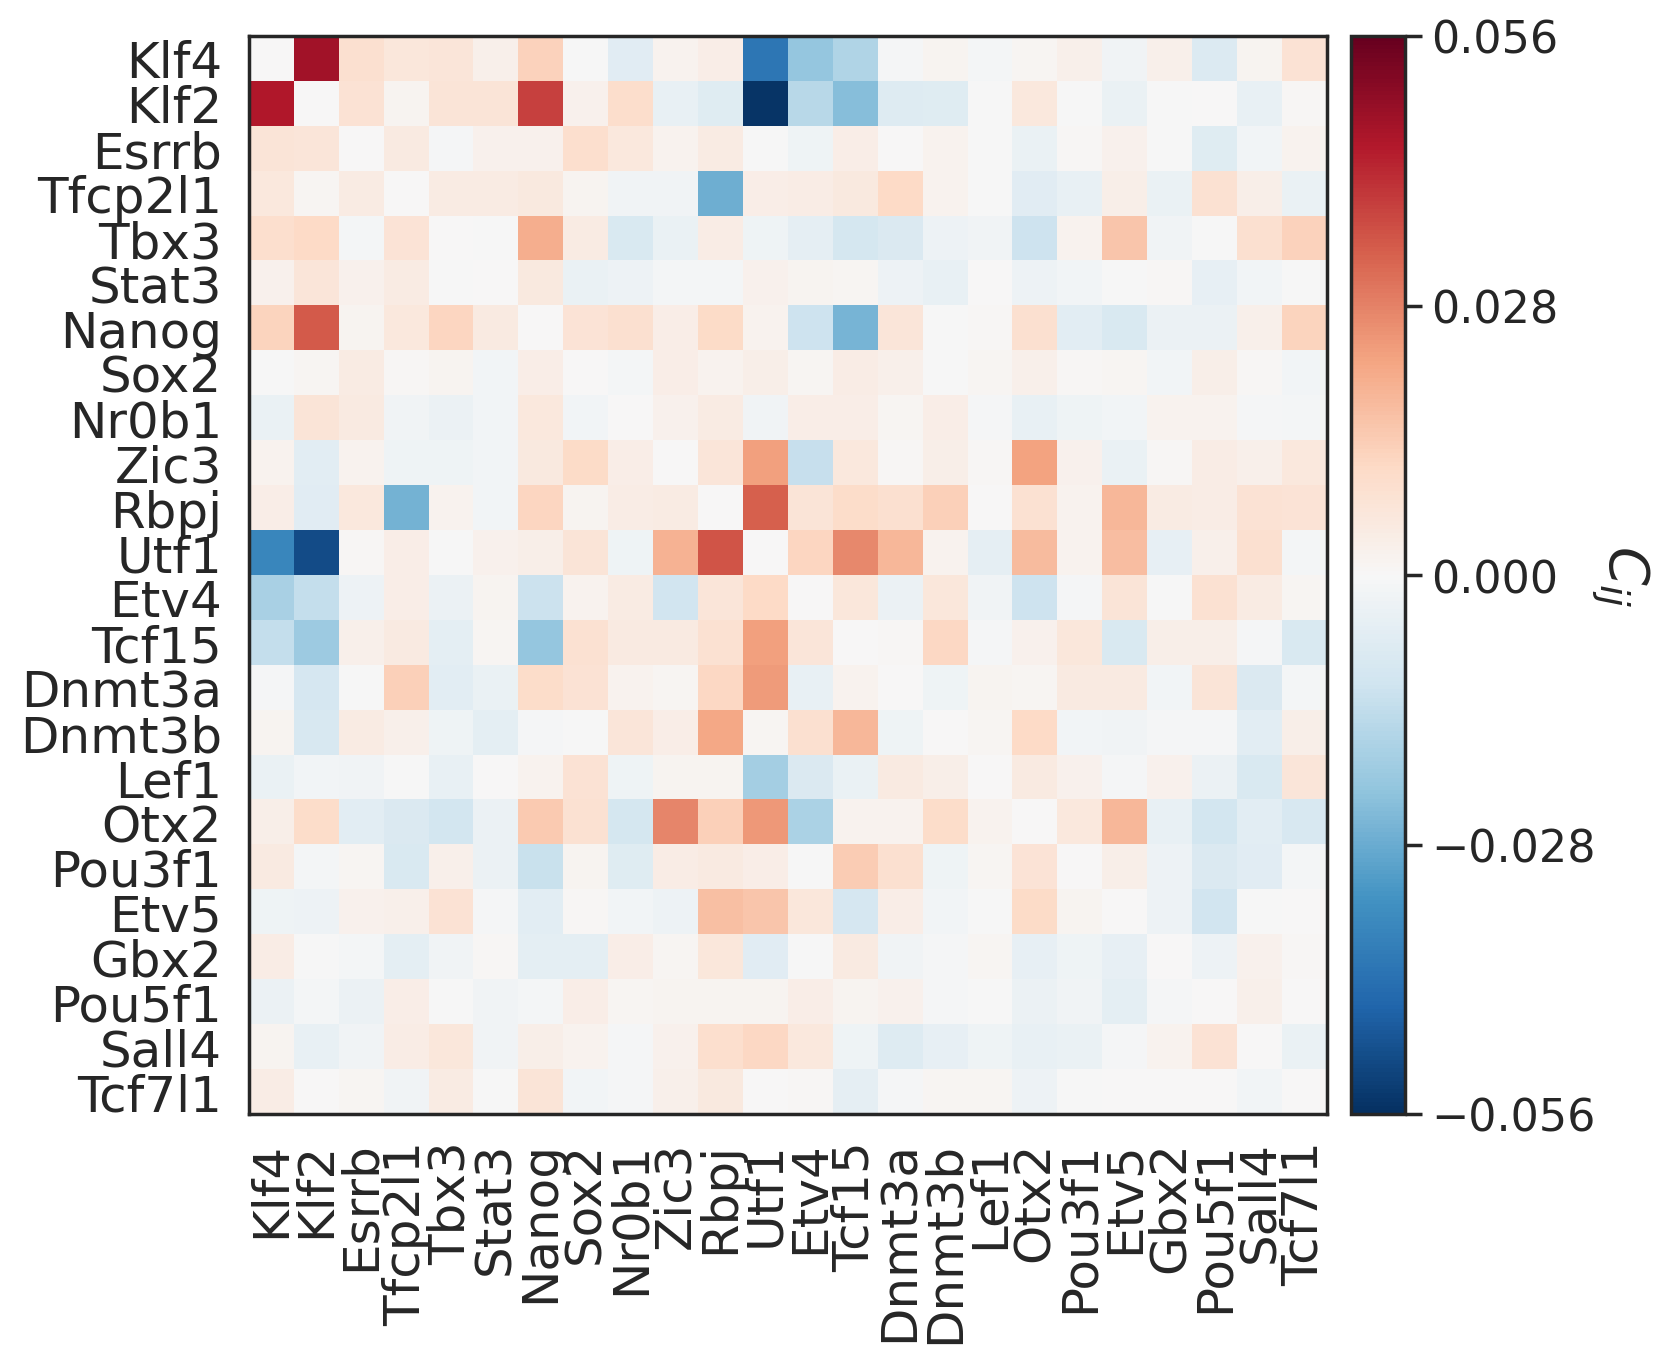

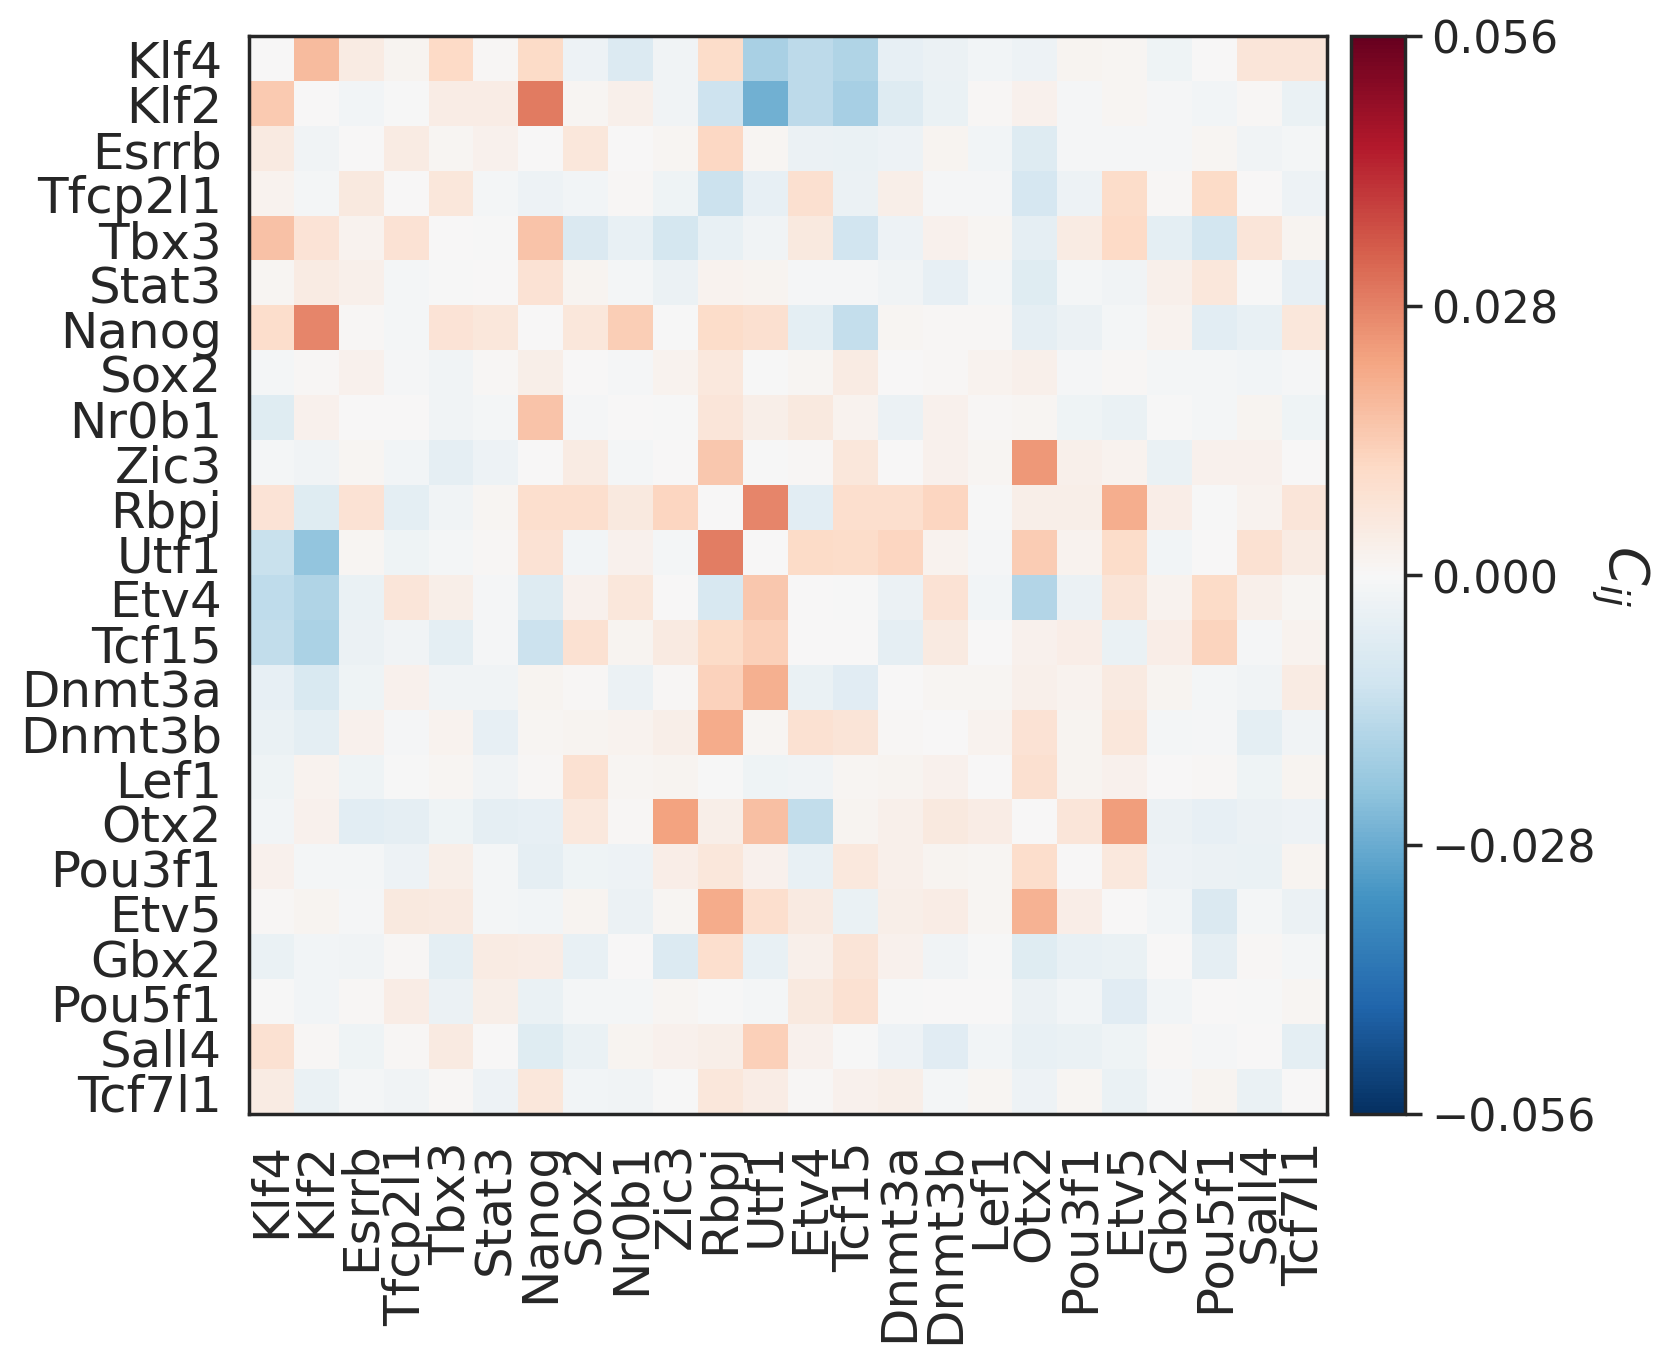

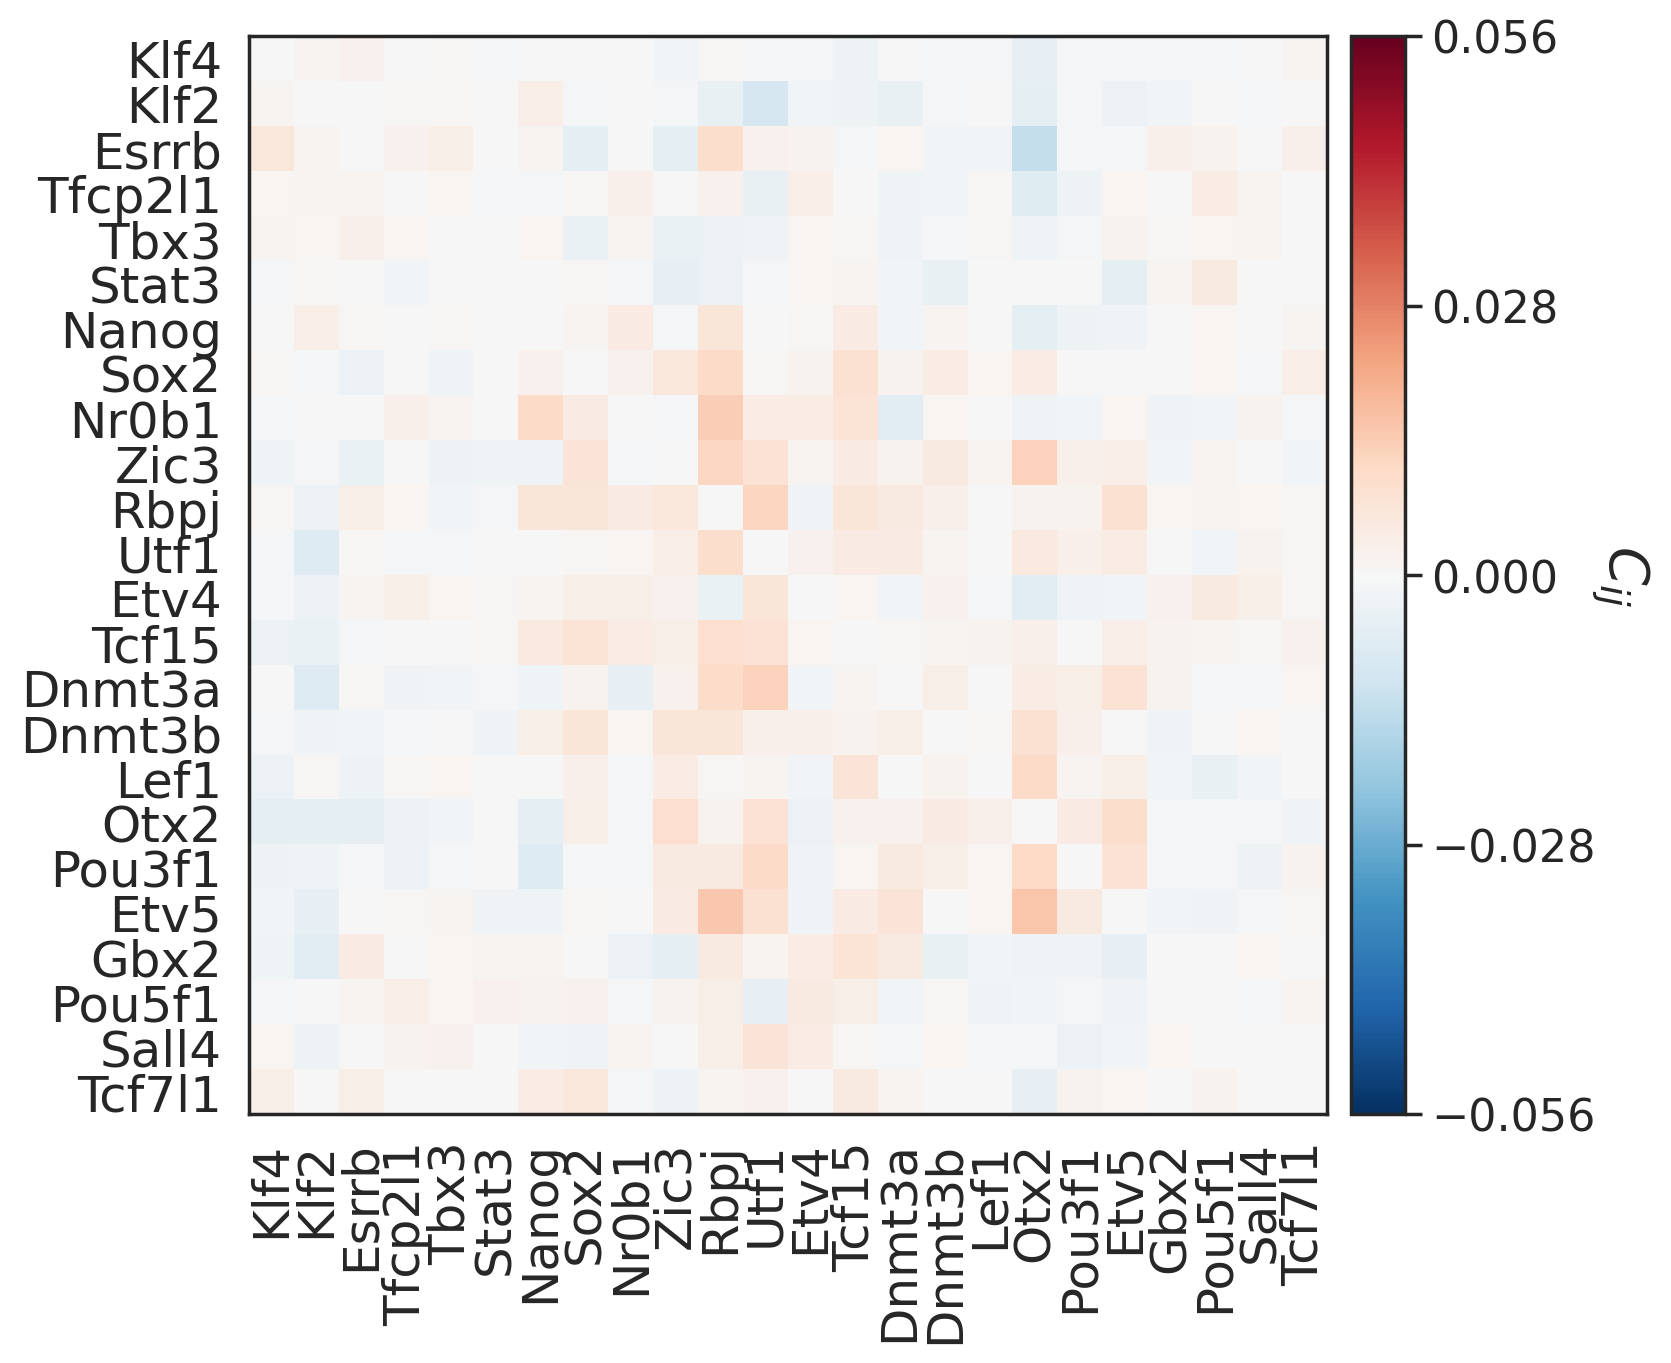

In [13]:
for index, matrix in enumerate(matrices, start=1):
    fig, ax = plt.subplots(1, 1, figsize=(8,7))
    fko.plotmat(matrix.T, fig, ax, genes_list, "", fix=False)  
    plt.savefig(f"GRN_Celloracle_LN_cl{index}.svg", format='svg', transparent=True)
    plt.show()
    plt.close(fig)


['Gbx2', 'Pou5f1', 'Sall4', 'Tcf7l1']
Total edges drawn: 10


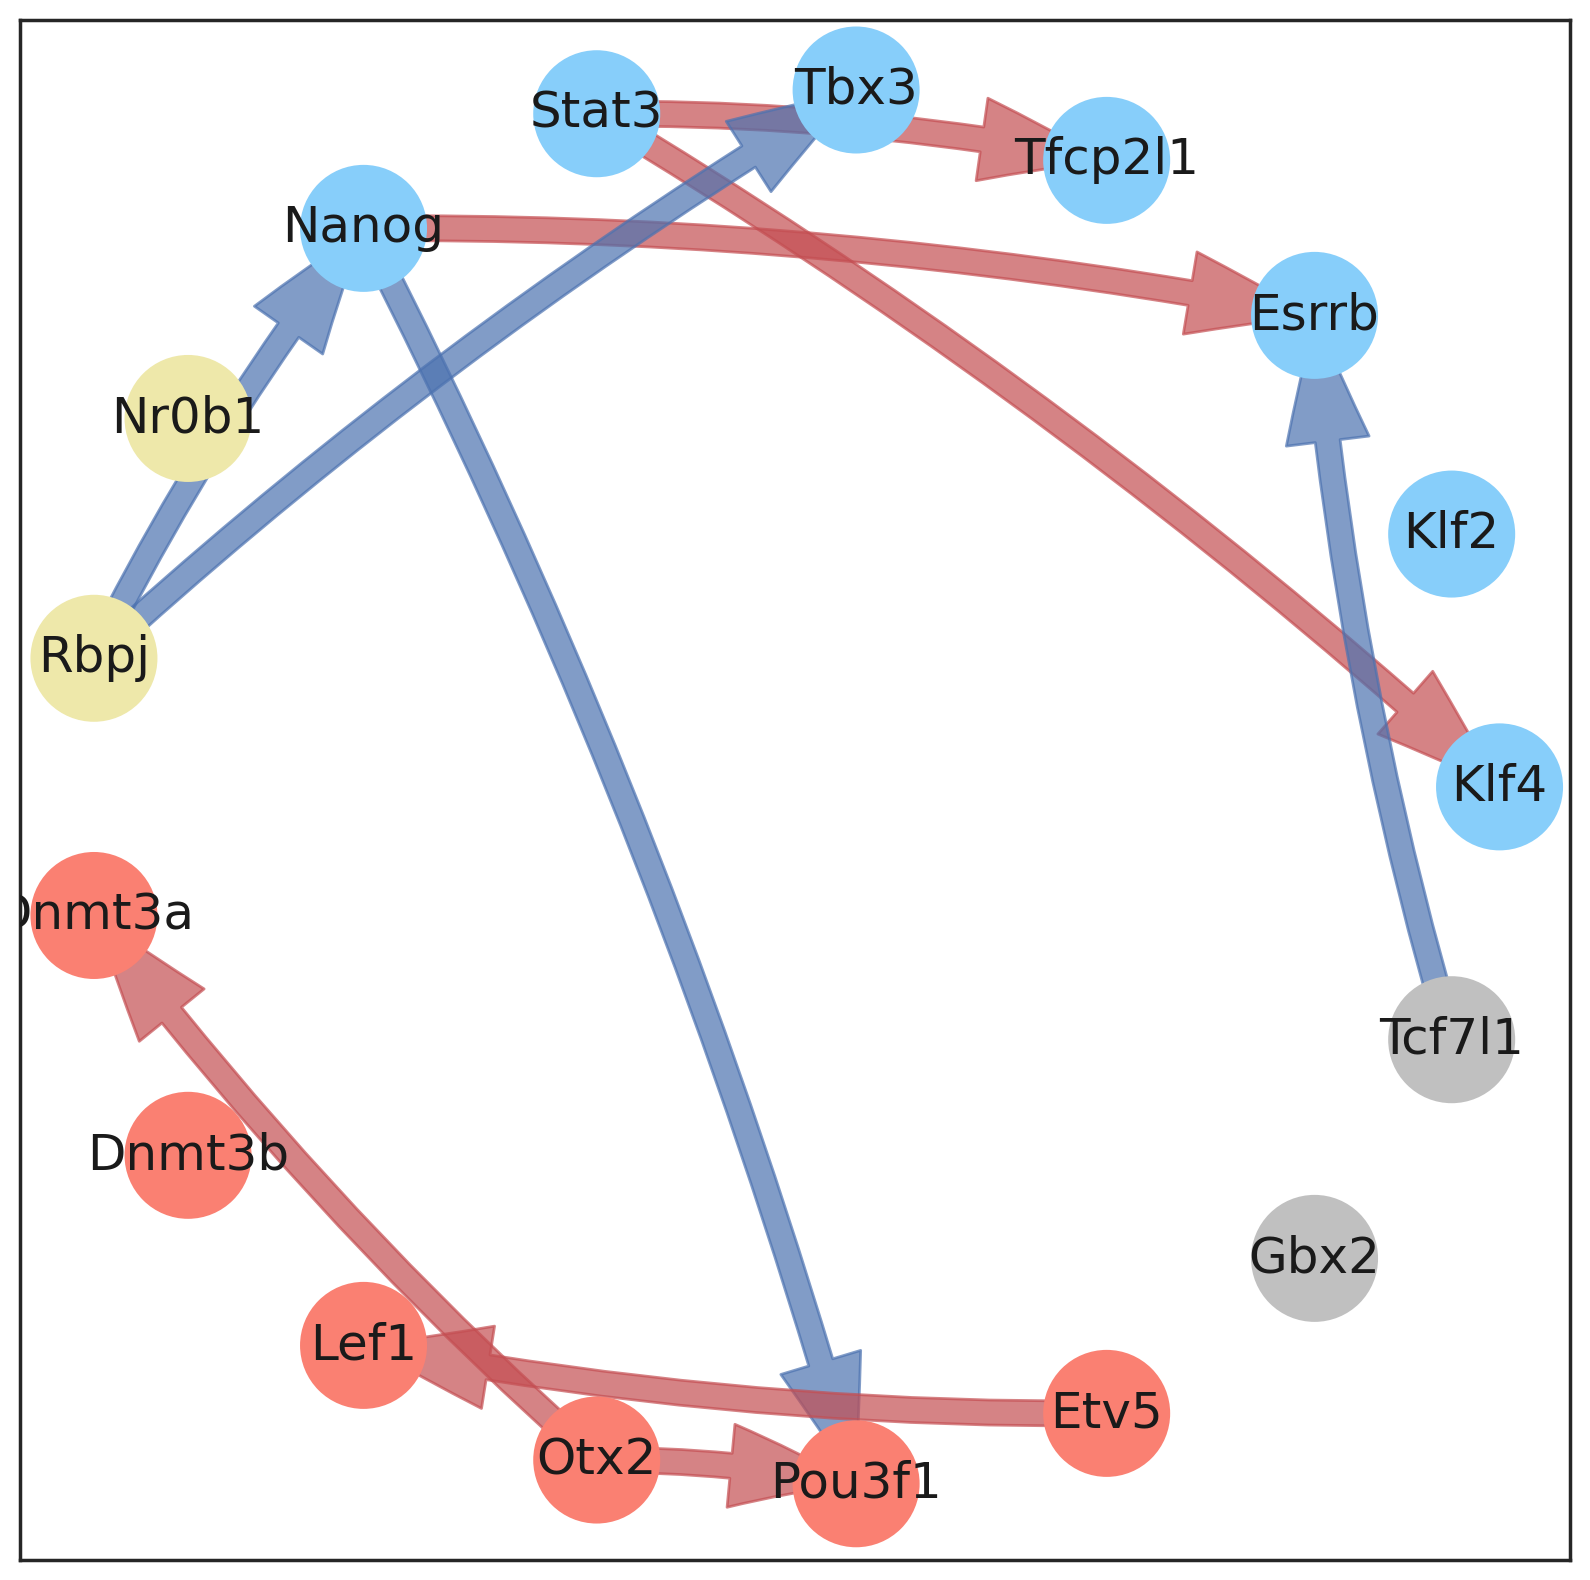

Total edges drawn: 12


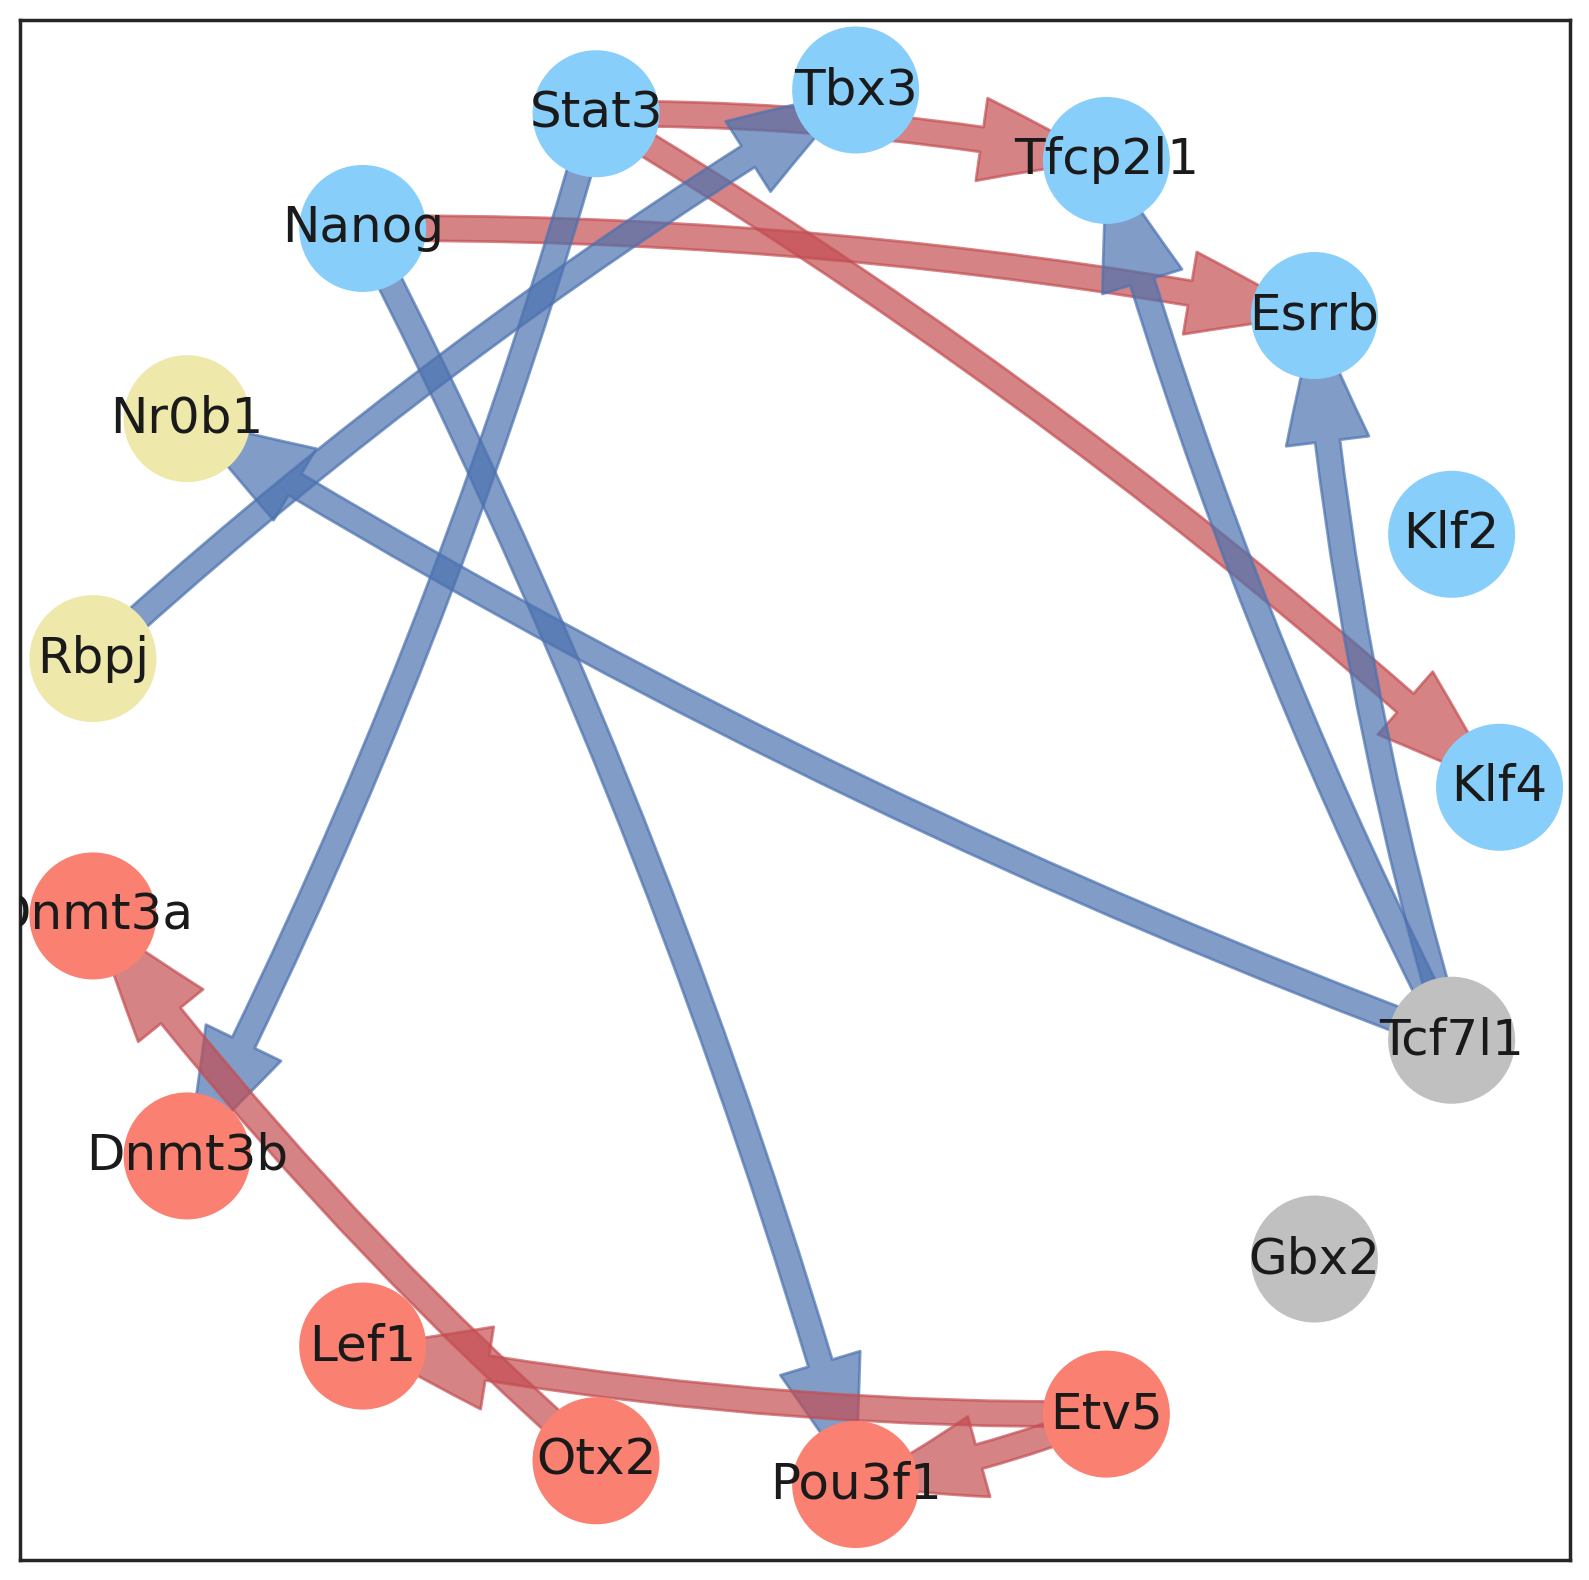

Total edges drawn: 11


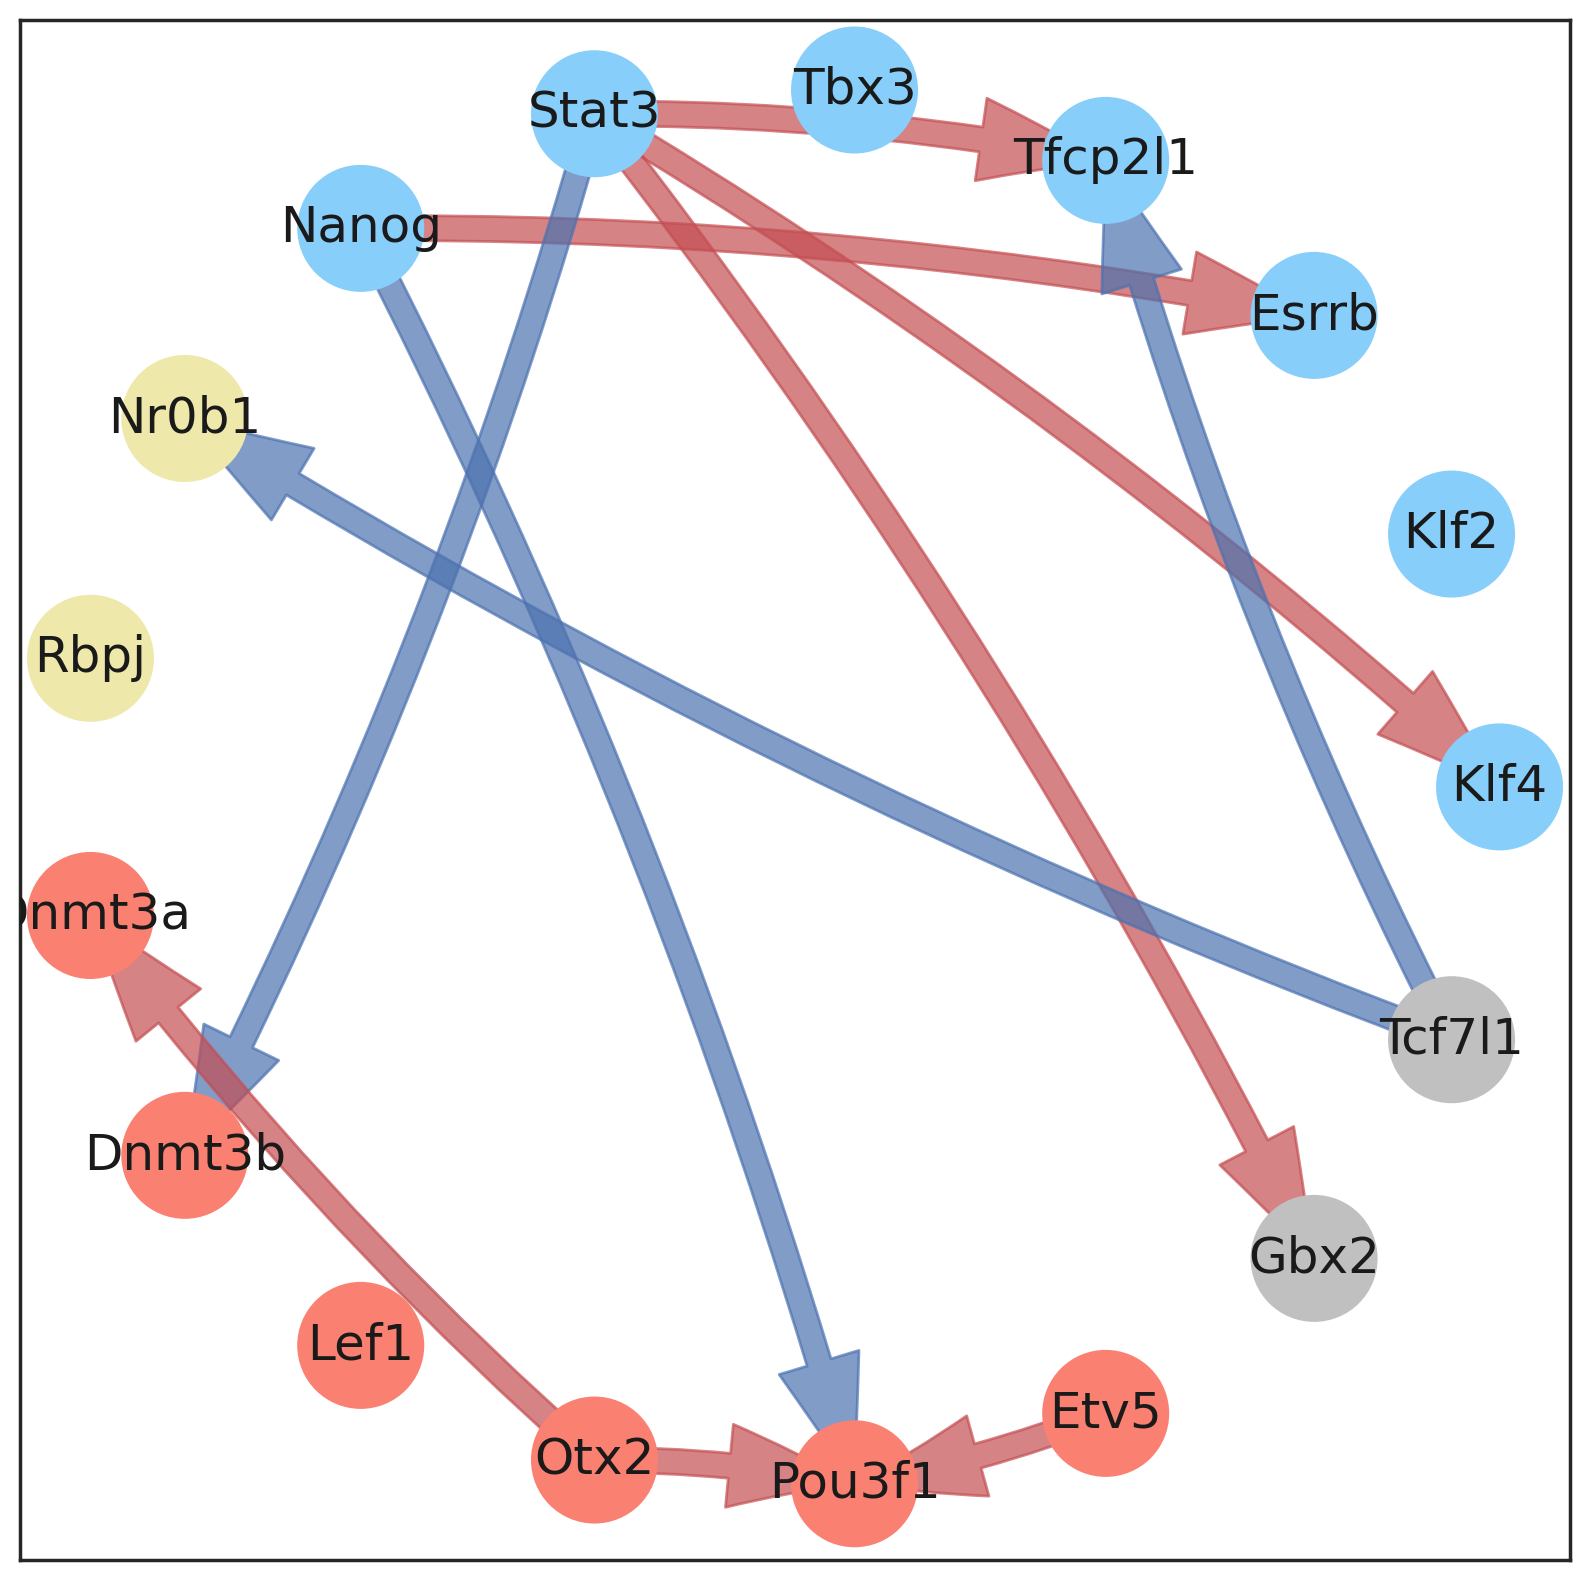

Total edges drawn: 15


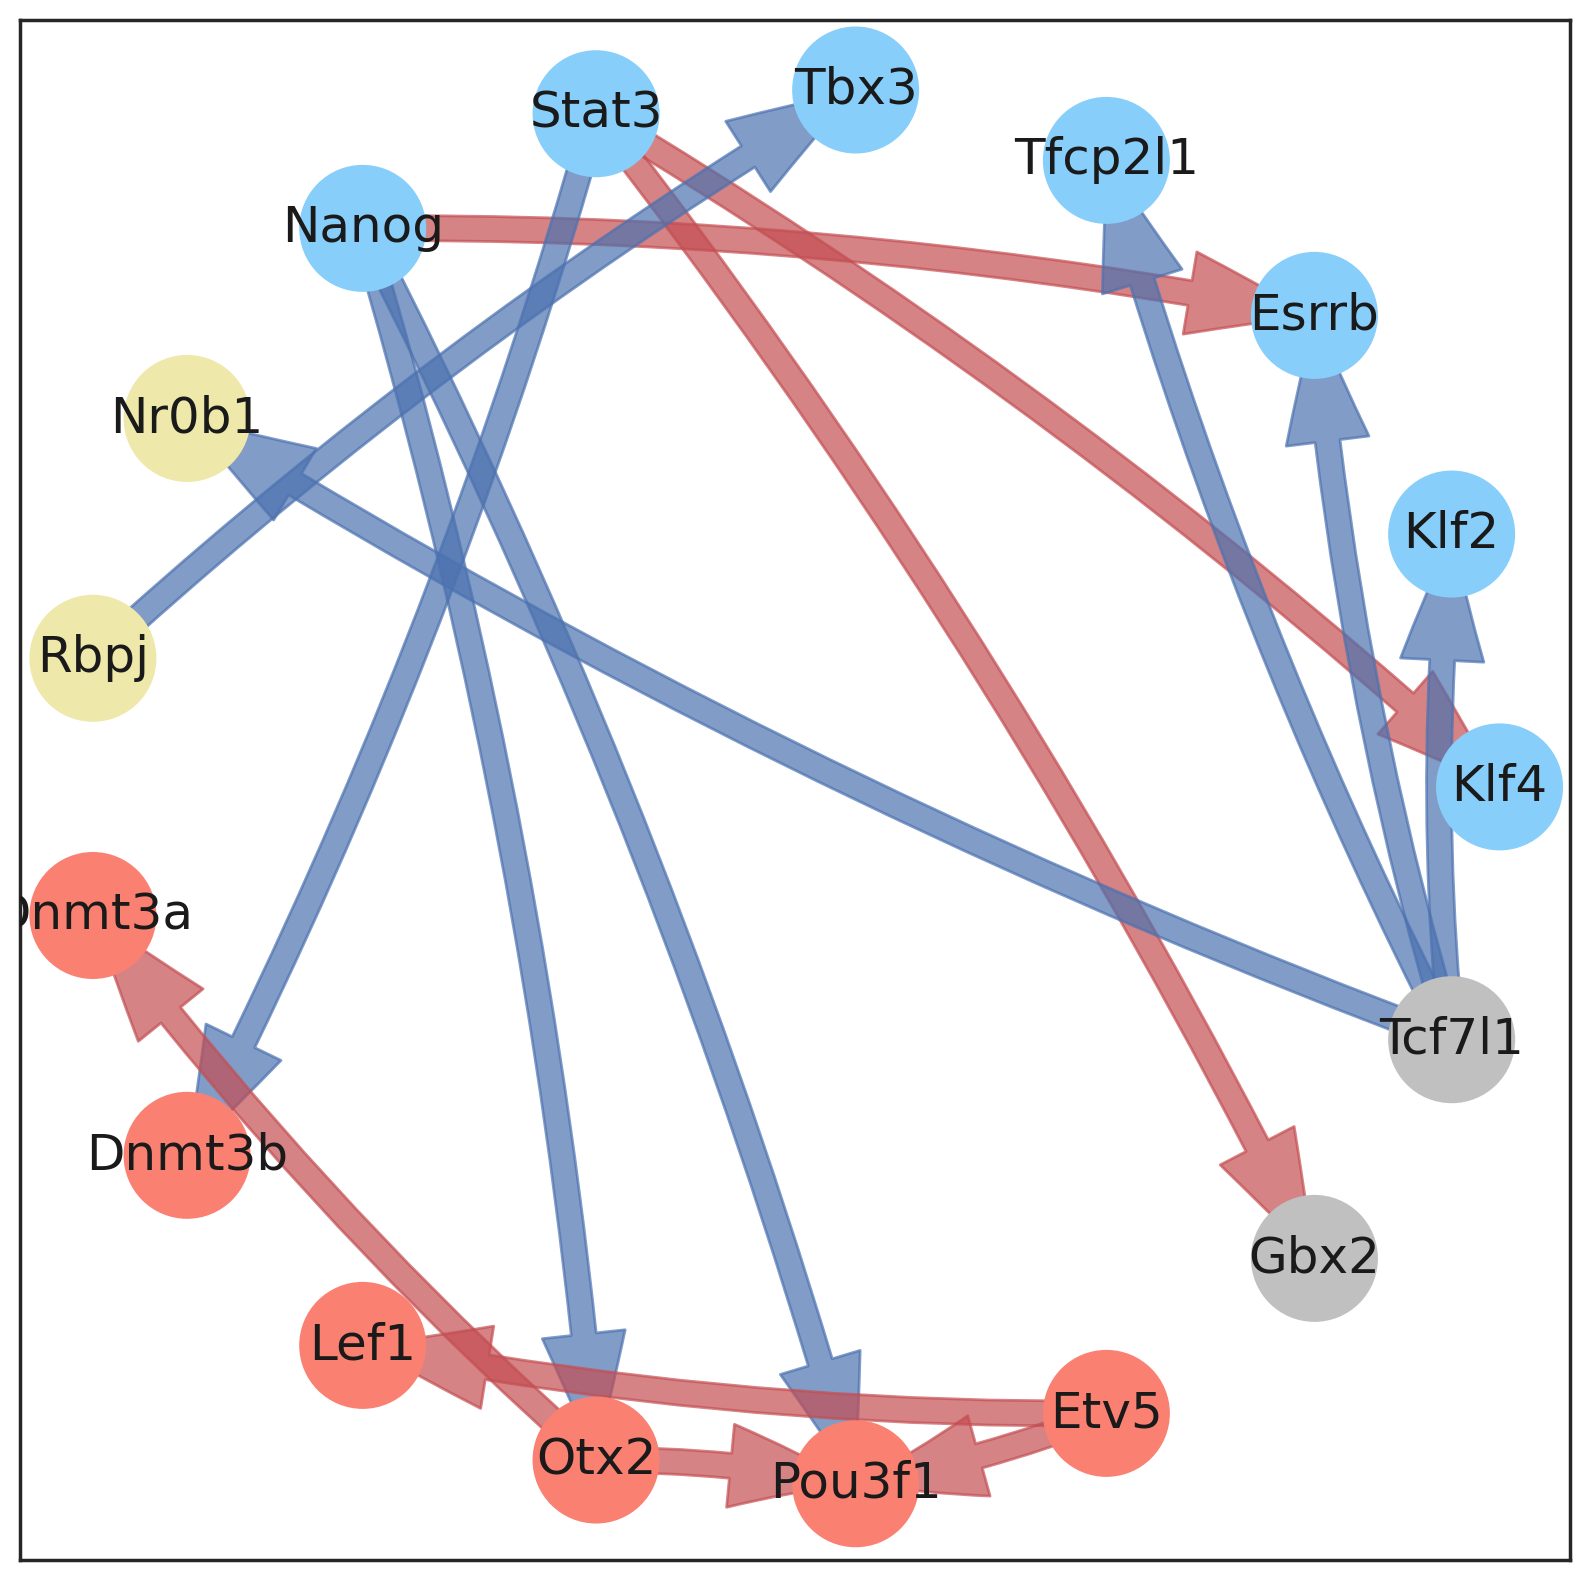

Total edges drawn: 12


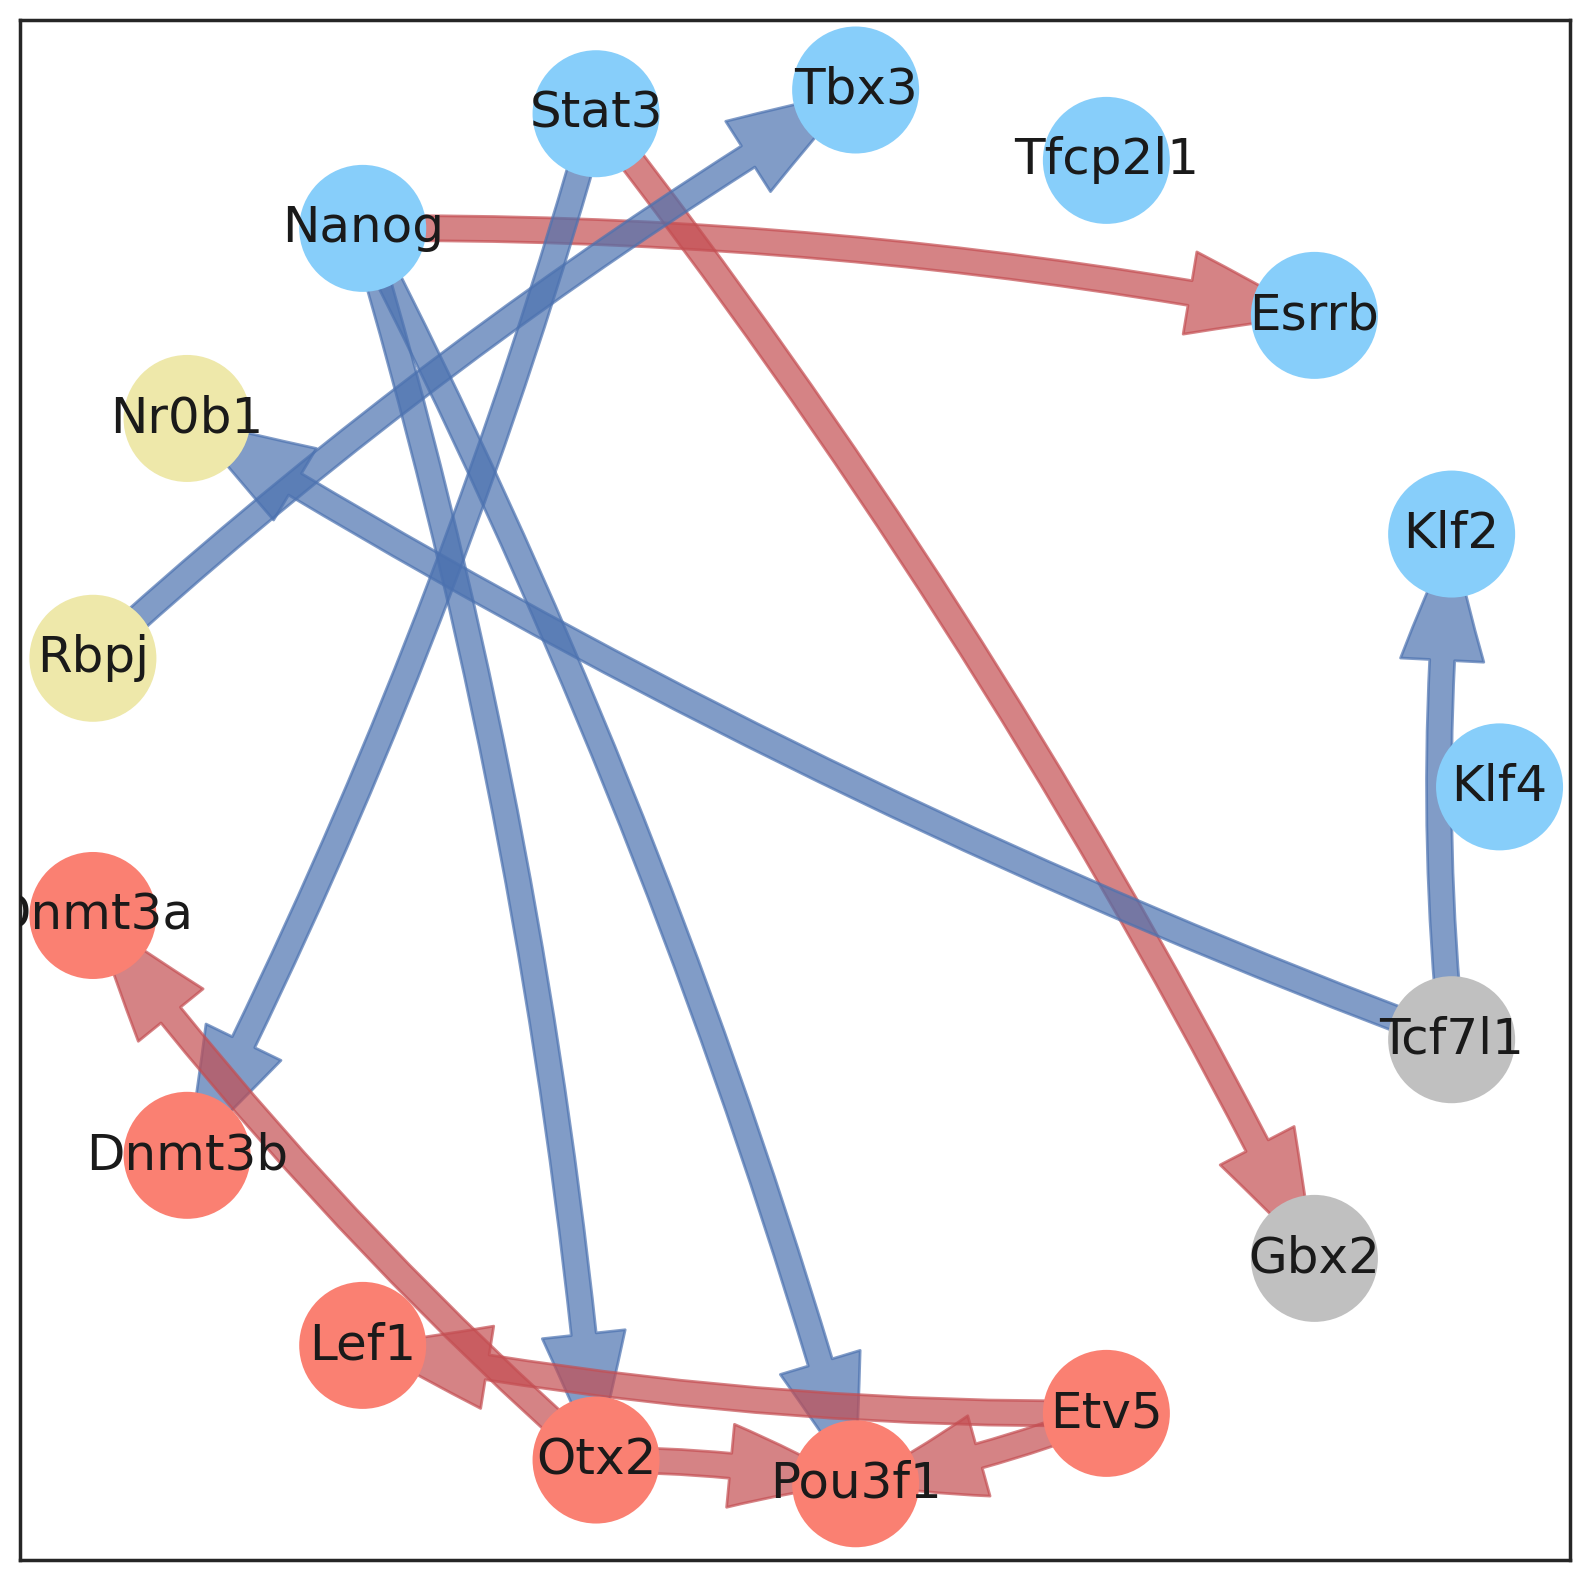

In [14]:
# Classifying genes based on the Carbognin paper (2023)
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative_early = ["Nr0b1", "Zic3", "Rbpj"]
formative_late = ["Utf1", "Etv4", "Tcf15", "Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]

# Identifying genes in the dataset that are not classified into the above categories
other = [x for x in genes_list if x not in naive and x not in formative_early and x not in formative_late]
print(other)
Known_Interactions_Exp = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


adj_matx2 = fko.to_adj_matrix(adjacency_matrix_2, thr = 0.0)
adj_matx3 = fko.to_adj_matrix(adjacency_matrix_3, thr = 0.0)
adj_matx4 = fko.to_adj_matrix(adjacency_matrix_4, thr = 0.0)
adj_matx5 = fko.to_adj_matrix(adjacency_matrix_5, thr = 0.0)
adj_matx6 = fko.to_adj_matrix(adjacency_matrix_6, thr = 0.0)


fko.visualize_graphSel(adj_matx2, genes_list, naive, formative_early, formative_late, Known_Interactions_Exp)
plt.savefig("GRN_Celloracle_LN_pst_mb_KInet_cl1.svg", format='svg',transparent = True, bbox_inches= 'tight')
plt.show()


fko.visualize_graphSel(adj_matx3, genes_list, naive, formative_early, formative_late, Known_Interactions_Exp)
plt.savefig("GRN_Celloracle_LN_pst_mb_KInet_cl2.svg", format='svg',transparent = True, bbox_inches= 'tight')
plt.show()


fko.visualize_graphSel(adj_matx4, genes_list, naive, formative_early, formative_late, Known_Interactions_Exp)
plt.savefig("GRN_Celloracle_LN_pst_mb_KInet_cl3.svg", format='svg',transparent = True, bbox_inches= 'tight')
plt.show()


fko.visualize_graphSel(adj_matx5, genes_list, naive, formative_early, formative_late, Known_Interactions_Exp)
plt.savefig("GRN_Celloracle_LN_pst_mb_KInet_cl4.svg", format='svg',transparent = True, bbox_inches= 'tight')
plt.show()


fko.visualize_graphSel(adj_matx6, genes_list, naive, formative_early, formative_late, Known_Interactions_Exp)
plt.savefig("GRN_Celloracle_LN_pst_mb_KInet_cl5.svg", format='svg',transparent = True, bbox_inches= 'tight')
plt.show()


In [15]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


result_2 = fko.check_signs(adjacency_matrix_2, TPtrial_list)
print(f"Fraction of correct signs in cluster 2: {result_2:.2f}")

result_3 = fko.check_signs(adjacency_matrix_3, TPtrial_list)
print(f"Fraction of correct signs  in cluster 3: {result_3:.2f}")

result_4 = fko.check_signs(adjacency_matrix_4, TPtrial_list)
print(f"Fraction of correct signs  in cluster 4: {result_4:.2f}")

result_5 = fko.check_signs(adjacency_matrix_5, TPtrial_list)
print(f"Fraction of correct signs in cluster 5: {result_5:.2f}")

result_6 = fko.check_signs(adjacency_matrix_6, TPtrial_list)
print(f"Fraction of correct signs in cluster 6: {result_6:.2f}")

Fraction of correct signs in cluster 2: 0.56
Fraction of correct signs  in cluster 3: 0.67
Fraction of correct signs  in cluster 4: 0.61
Fraction of correct signs in cluster 5: 0.83
Fraction of correct signs in cluster 6: 0.67


In [16]:
fci_cls = np.array([result_2, result_3, result_4, result_5, result_6])
mean_fci = np.mean(fci_cls)
std_fci  = np.std(fci_cls)/np.sqrt(len(fci_cls))
print("mean:", np.round(mean_fci,3), "\nstd: ", np.round(std_fci,3))


mean: 0.667 
std:  0.042


# 2. Make predictive models for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [17]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
# Original Data
gene_expression_matx_input =  oracle.adata.layers["imputed_count"]

# create a dataframe from gene_expression_matx_input where the columns are the genes
df_input = pd.DataFrame(gene_expression_matx_input, columns=oracle.adata.var["SYMBOL"])
df_input_imp_genes_wt = df_input[genes_list] # select the column of the genes of interest (all genes present in genes_list)

corr_matx_original = np.corrcoef(df_input_imp_genes_wt.T)


In [19]:
# Shuffled data
N_rows = df_input_imp_genes_wt.T.shape[0]
N_cols = df_input_imp_genes_wt.T.shape[1]
Ntest = 50

# Linearize
val_rnd = np.reshape(np.array(df_input_imp_genes_wt.T), (N_cols*N_rows))

# reshuflle for Ntest times
df_shuffled = np.zeros((Ntest, N_rows, N_cols))

for ii in range(Ntest):
    np.random.seed(1234+ii)
    # Random reshuffle of the binnarized GE data
    np.random.shuffle(val_rnd)
    val_rnd_matx = val_rnd.reshape(N_rows,N_cols) # Reshape to the original shape
    trial_long = pd.DataFrame(val_rnd_matx)

    # Save the shuffled DataFrame
    df_shuffled[ii,:,:] = trial_long

#  For shuffled input data
corr_matxs_rnd = np.array([np.corrcoef(df_shuffled[i,:,:]) for i in range(df_shuffled.shape[0])])
# distance for shuffled data
noise_dist = np.mean([fko.sum_squared_abs_diff(corr_matx_original, corr_matxs_rnd[i,:,:]) for i in range(df_shuffled.shape[0])])


In [20]:
oracle.simulate_shift(perturb_condition={},
                      n_propagation=3)

simulated_expression_matrix_KO = oracle.adata.layers['simulated_count']

# same for simulated_expression_matrix_KO
df_simulated_wt = pd.DataFrame(simulated_expression_matrix_KO, columns=oracle.adata.var["SYMBOL"])
df_simulated_imp_genes_wt = df_simulated_wt[genes_list]

In [21]:
identical = df_input_imp_genes_wt.equals(df_simulated_imp_genes_wt)
identical

True

In [22]:
wt_input =  oracle.adata.layers["imputed_count"]
wt_gen =  oracle.adata.layers["simulated_count"]
wt_norm = oracle.adata.layers["normalized_count"]
wt_ln = oracle.adata.layers["logcounts"]

matrices_are_equal = np.array_equal(wt_gen, wt_input)
print(matrices_are_equal)

# for important genes
df_wt_input = (pd.DataFrame(wt_input, columns=oracle.adata.var["SYMBOL"]))
df_wt_gen = (pd.DataFrame(wt_gen, columns=oracle.adata.var["SYMBOL"]))
df_wt_ln = (pd.DataFrame(wt_ln, columns=oracle.adata.var["SYMBOL"]))
df_wt_norm = (pd.DataFrame(wt_norm, columns=oracle.adata.var["SYMBOL"]))


df_wt_input_rel_genes = (pd.DataFrame(wt_input, columns=oracle.adata.var["SYMBOL"]))[genes_list]
df_wt_gen_rel_genes = (pd.DataFrame(wt_gen, columns=oracle.adata.var["SYMBOL"]))[genes_list]
df_wt_ln_rel_genes = (pd.DataFrame(wt_ln, columns=oracle.adata.var["SYMBOL"]))[genes_list]
df_wt_norm_rel_genes = (pd.DataFrame(wt_norm, columns=oracle.adata.var["SYMBOL"]))[genes_list]

True


In [23]:
# df_wt_input.to_csv('co_wt_input.csv', index=True, header=True)
# df_wt_gen.to_csv('co_wt_gen.csv', index=True, header=True)
# df_wt_ln.to_csv('co_wt_ln.csv', index=True, header=True)
# df_wt_norm.to_csv('co_wt_norm.csv', index=True, header=True)


In [24]:
corr_matx_sim = np.corrcoef(df_simulated_imp_genes_wt.T)
are_equal = np.array_equal(corr_matx_original, corr_matx_sim)
if are_equal:
    print("correlation matrices are equal")
else:
    dist = fko.sum_squared_abs_diff(corr_matx_original, corr_matx_sim) / noise_dist # normalize by the noise
    print("matrices distance: ", dist)


correlation matrices are equal


# 3. In silico TF perturbation analysis

Next, we will simulate the TF perturbation effects on cell identity to investigate its potential functions and regulatory mechanisms. Please see the CellOracle paper for more details on scientific rationale.

In this notebook, we will simulate the knockout of the Gata1 gene in the hematopoiesis trajectory.

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation.

Here, we will use CellOracle to analyze Gata1 and attempt to recapitulate the previous findings from above.


## 3.1. Check gene expression pattern.

In [25]:
# # Check gene expression 
# goi = "Rbpj"
# sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
#                  layer="imputed_count", use_raw=False, cmap="viridis")

In [26]:
# # Plot gene expression in histogram
# sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
# plt.show()

## 3.2. Calculate future gene expression after perturbation.

- You can use any gene expression value in the in silico perturbations, but please avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.



### Experimental log2FC single KO data

In [27]:
df_KO_N24_Leeb_uncl = pd.read_csv(path+'/df_KO_N24_uncleaned.csv', index_col=0, header=0)


# plt.figure(figsize=(7,9))
# # annotate using 3 decimal places
# sns.heatmap(np.array(df_KO_N24_Leeb_uncl).astype(float), annot=True, fmt=".2f", 
#             xticklabels=df_KO_N24_Leeb_uncl.columns, yticklabels=df_KO_N24_Leeb_uncl.index, 
#            cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)
# plt.title("Log2FC (N24)", fontsize=20)
# plt.show()

df_KO_N24_Leeb_uncl.head(2)


Rbpj      Etv5    Tcf7l1
Klf4  2.890194  2.386695  1.300426
Klf2  0.492426  1.008604  2.338680

In [28]:
# check if the genes in the list are in the experimental single KO log2FC dataframe with the same order
np.array(df_KO_N24_Leeb_uncl.index) == np.array(genes_list)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

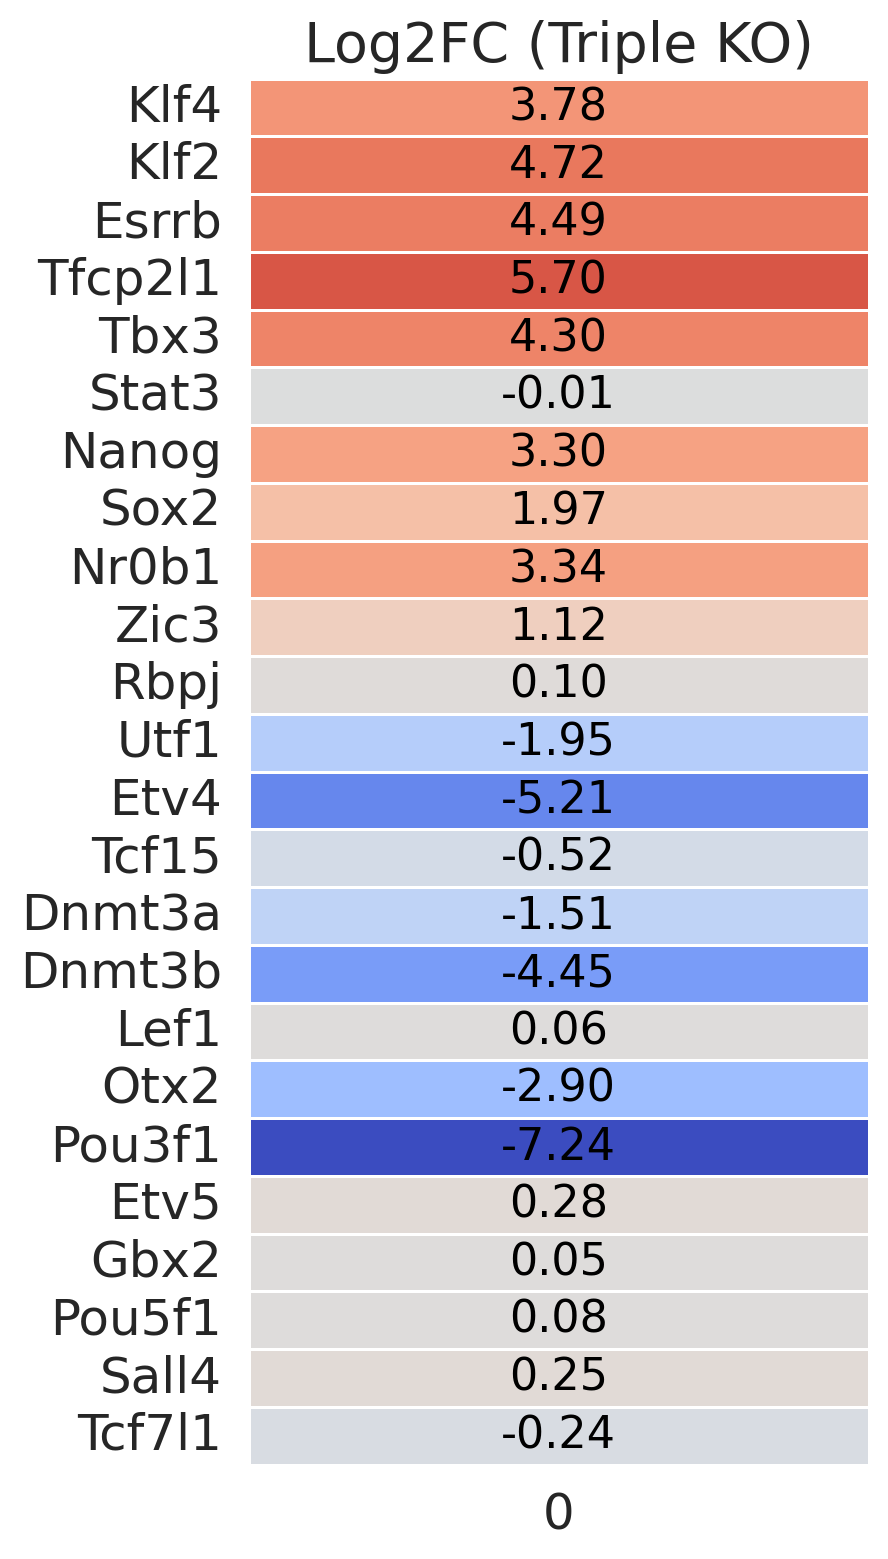

In [29]:
df_tKO_Kalkan = pd.read_csv('df_tripleKO_diff.csv', index_col=0, header=0)

plt.figure(figsize=(4,9))
sns.heatmap(np.array(df_tKO_Kalkan).astype(float), annot=True, fmt=".2f", 
            xticklabels=df_tKO_Kalkan.columns, yticklabels=df_tKO_Kalkan.index, 
           cmap="coolwarm", cbar=False, center=0, linewidth=.5, annot_kws={"size":16, 'color':'black'})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Log2FC (Triple KO)", fontsize=20)
plt.show()

In [30]:
print("Data types:", oracle.adata.layers)
gene_expression_matx_input =  oracle.adata.layers["imputed_count"]
print("Original Data: ", gene_expression_matx_input.shape)

df_input_imp_genes = df_wt_input_rel_genes.copy() 

Data types: Layers with keys: logcounts, raw_count, normalized_count, imputed_count, simulation_input, simulated_count, delta_X
Original Data:  (9696, 2078)


### 3.2.1 Rbpj

In [31]:
goi = "Rbpj"
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

# Gene expression matrices 
simulated_expression_matrix_KO = oracle.adata.layers['simulated_count']

print("Simulated data", simulated_expression_matrix_KO.shape)
print("genes", len(oracle.adata.var["SYMBOL"]))

Simulated data (9696, 2078)
genes 2078


In [32]:
# same for simulated_expression_matrix_KO
df_simulated = pd.DataFrame(simulated_expression_matrix_KO, columns=oracle.adata.var["SYMBOL"])
# df_simulated_imp_genes = df_simulated[genes_list]
df_simulated_imp_genes = df_simulated[genes_list]


#  Remove KO gene
df_input_imp_genes.drop(columns=[goi], inplace=True)
df_simulated_imp_genes.drop(columns=[goi], inplace=True)

# Averaging over cells, for each gene
column_means = np.mean(df_input_imp_genes, axis=0)
column_means_KO = np.mean(df_simulated_imp_genes, axis=0)

print(column_means.shape, column_means_KO.shape)
diff_Rbpj = fko.KO_diff_sim(column_means_KO, column_means)


(23,) (23,)


### 3.2.2 Etv5

In [33]:
goi = "Etv5"
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={"Etv5": 0.0},
                      n_propagation=3)

# Gene expression matrices from raw count, imputed count, and simulated count
simulated_expression_matrix_KO = oracle.adata.layers['simulated_count']

# create a dataframe from gene_expression_matx_input where the columns are the genes
df_input = pd.DataFrame(gene_expression_matx_input, columns=oracle.adata.var["SYMBOL"])
df_input_imp_genes = df_wt_input_rel_genes.copy() # select the column of the genes of interest (all genes present in genes_list)

# same for simulated_expression_matrix_KO
df_simulated = pd.DataFrame(simulated_expression_matrix_KO, columns=oracle.adata.var["SYMBOL"])
df_simulated_imp_genes = df_simulated[genes_list]

#  Remove KO gene
df_input_imp_genes.drop(columns=[goi], inplace=True)
df_simulated_imp_genes.drop(columns=[goi], inplace=True)

# Averaging over cells, for each gene
column_means = np.mean(df_input_imp_genes, axis=0)
column_means_KO = np.mean(df_simulated_imp_genes, axis=0)

print(column_means.shape, column_means_KO.shape)


diff_Etv5 = fko.KO_diff_sim(column_means_KO, column_means)




(23,) (23,)


### 3.2.3 Tcf7l1

In [34]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
goi = "Tcf7l1"
oracle.simulate_shift(perturb_condition={"Tcf7l1": 0.0},
                      n_propagation=3)

# Gene expression matrices from raw count, imputed count, and simulated count
simulated_expression_matrix_KO = oracle.adata.layers['simulated_count']

# create a dataframe from gene_expression_matx_input where the columns are the genes
df_input = pd.DataFrame(gene_expression_matx_input, columns=oracle.adata.var["SYMBOL"])
df_input_imp_genes = df_wt_input_rel_genes.copy() # select the column of the genes of interest (all genes present in genes_list)

# same for simulated_expression_matrix_KO
df_simulated = pd.DataFrame(simulated_expression_matrix_KO, columns=oracle.adata.var["SYMBOL"])
df_simulated_imp_genes = df_simulated[genes_list]

#  Remove KO gene
df_input_imp_genes.drop(columns=[goi], inplace=True)
df_simulated_imp_genes.drop(columns=[goi], inplace=True)

# Averaging over cells, for each gene
column_means = np.mean(df_input_imp_genes, axis=0)
column_means_KO = np.mean(df_simulated_imp_genes, axis=0)

print(column_means.shape, column_means_KO.shape)

diff_Tcf7l1 = fko.KO_diff_sim(column_means_KO, column_means)



(23,) (23,)


### 3.2.4 Triple KO

In [35]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={"Rbpj": 0.0, "Etv5": 0.0, "Tcf7l1": 0.0},
                      n_propagation=3)

# Gene expression matrices from raw count, imputed count, and simulated count
simulated_expression_matrix_KO = oracle.adata.layers['simulated_count']

# create a dataframe from gene_expression_matx_input where the columns are the genes
df_input = pd.DataFrame(gene_expression_matx_input, columns=oracle.adata.var["SYMBOL"])
df_input_imp_genes = df_wt_input_rel_genes.copy() # select the column of the genes of interest (all genes present in genes_list)

# same for simulated_expression_matrix_KO
df_simulated = pd.DataFrame(simulated_expression_matrix_KO, columns=oracle.adata.var["SYMBOL"])
df_simulated_imp_genes = df_simulated[genes_list]

#  Remove KO gene
genes_to_remove = ["Rbpj", "Etv5", "Tcf7l1"]
df_input_imp_genes.drop(columns=genes_to_remove, inplace=True)
df_simulated_imp_genes.drop(columns=genes_to_remove, inplace=True)


# Averaging over cells, for each gene
column_means = np.mean(df_input_imp_genes, axis=0)
column_means_KO = np.mean(df_simulated_imp_genes, axis=0)

print(column_means.shape, column_means_KO.shape)

diff_triple = fko.KO_diff_sim(column_means_KO, column_means)

(21,) (21,)


In [36]:
# saving data to analyse them
df_wt_input.to_csv('df_wt_input_all_genes.csv', index=False)
df_simulated.to_csv('df_triple_KO_input_all_genes.csv', index=False)

print(df_wt_input.shape, df_simulated.shape)

(9696, 2078) (9696, 2078)


## 3.3 Visualization of the results for KO

In [37]:
log2fc_Rbpj = df_KO_N24_Leeb_uncl.iloc[:,0]
log2fc_Rbpj = log2fc_Rbpj[log2fc_Rbpj.index != "Rbpj"]
print(log2fc_Rbpj.shape)

log2fc_Etv5 = df_KO_N24_Leeb_uncl.iloc[:,1]
log2fc_Etv5 = log2fc_Etv5[log2fc_Etv5.index != "Etv5"]
print(log2fc_Etv5.shape)

log2fc_Tcf7l1 = df_KO_N24_Leeb_uncl.iloc[:,2]
log2fc_Tcf7l1= log2fc_Tcf7l1[log2fc_Tcf7l1.index != "Tcf7l1"]
print(log2fc_Tcf7l1.shape)

# Triple KO
df_tKO_Kalkan.drop(index=genes_to_remove, inplace=True)
df_tKO_Kalkan.shape


(23,)
(23,)
(23,)


(21, 1)

In [38]:
# Max Abs Value for normalization in EXP data
max_exp = max(abs(log2fc_Rbpj).max(), abs(log2fc_Etv5).max(), abs(log2fc_Tcf7l1).max())

# CHECK:
# Trova il nome della colonna con il massimo valore
col_name_max = abs(df_KO_N24_Leeb_uncl).max().idxmax()

# Trova il nome della riga con il massimo valore in quella colonna
row_name_max = df_KO_N24_Leeb_uncl[col_name_max].abs().idxmax()

print("max of exp Log2FC:", max_exp, )
print("for KO of gene:", col_name_max)
print("for the gene:", row_name_max)

# Triple KO
abs_max_kalkan = df_tKO_Kalkan.abs().max().max()
print("Triple Ko max(abs): ", abs_max_kalkan)

max of exp Log2FC: 3.6146207248390487
for KO of gene: Rbpj
for the gene: Tbx3
Triple Ko max(abs):  7.2384047393250786


In [39]:
# Find the maximum value among the three series
max_sim_data = max(abs(diff_Tcf7l1).max(), abs(diff_Etv5).max(), abs(diff_Rbpj).max(), abs(diff_triple).max())

print("Maximum among the three series:", max_sim_data)


Maximum among the three series: 0.3007571205392626


In [40]:
gene_to_check = "Rbpj"
if (gene_to_check in log2fc_Rbpj.index) or (gene_to_check in diff_Rbpj.index):
    print(f"The gene {gene_to_check} is still present in the Series.")
else:
    print(f"The gene {gene_to_check} has been removed from the Series.")

gene_to_check = "Etv5"
if (gene_to_check in log2fc_Etv5.index) or (gene_to_check in diff_Etv5.index):
    print(f"The gene {gene_to_check} is still present in the Series.")
else:
    print(f"The gene {gene_to_check} has been removed from the Series.")
    
gene_to_check = "Tcf7l1"
if (gene_to_check in log2fc_Tcf7l1.index) or (gene_to_check in diff_Tcf7l1.index):
    print(f"The gene {gene_to_check} is still present in the Series.")
else:
    print(f"The gene {gene_to_check} has been removed from the Series.")
    
print(diff_Rbpj.shape, log2fc_Rbpj.shape)
print(diff_Etv5.shape, log2fc_Etv5.shape)
print(diff_Tcf7l1.shape, log2fc_Tcf7l1.shape)

The gene Rbpj has been removed from the Series.
The gene Etv5 has been removed from the Series.
The gene Tcf7l1 has been removed from the Series.
(23,) (23,)
(23,) (23,)
(23,) (23,)


In [41]:
gene_KO = "Rbpj"
KO_genes_reference_R = [gene for gene in genes_list if gene not in gene_KO]
len(KO_genes_reference_R)

gene_KO = "Etv5"
KO_genes_reference_E = [gene for gene in genes_list if gene not in gene_KO]
len(KO_genes_reference_E)

gene_KO = "Tcf7l1"
KO_genes_reference_T = [gene for gene in genes_list if gene not in gene_KO]
len(KO_genes_reference_E)

gene_KO = ["Rbpj", "Etv5", "Tcf7l1"]
KO_genes_reference = [gene for gene in genes_list if gene not in gene_KO]
len(KO_genes_reference)


21

In [42]:
# Normalized differences
diff_sim   = np.array([diff_Rbpj, diff_Etv5, diff_Tcf7l1])
log2FC_exp = np.array([log2fc_Rbpj, log2fc_Etv5, log2fc_Tcf7l1])
genes_KOs  = np.array([KO_genes_reference_R, KO_genes_reference_E, KO_genes_reference_T])
KO_goodness_sel = np.zeros(4)

diff_max = max_sim_data.copy()
diff_sim_norm = diff_sim/diff_max
diff_sim_T_norm = diff_triple/diff_max

log2FC_exp_norm = log2FC_exp/np.abs(log2FC_exp).max()
df_tKO_Kalkan_norm = df_tKO_Kalkan/np.abs(df_tKO_Kalkan).max()

diff_thr = 0.05

# Rbpj
print(fko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr))
KO_goodness_sel[0] = fko.fraction_agreement(diff_sim_norm[0,:], log2FC_exp_norm[0,:], genes_KOs[0,:], diff_thr)[3]
# Etv5
print(fko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr))
KO_goodness_sel[1] = fko.fraction_agreement(diff_sim_norm[1,:], log2FC_exp_norm[1,:], genes_KOs[1,:], diff_thr)[3]
# Tcf7l1
print(fko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr))
KO_goodness_sel[2] = fko.fraction_agreement(diff_sim_norm[2,:], log2FC_exp_norm[2,:], genes_KOs[2,:], diff_thr)[3]
# Triple
print(fko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(KO_genes_reference), diff_thr))
KO_goodness_sel[3] = fko.fraction_agreement(diff_sim_T_norm, np.array(df_tKO_Kalkan_norm).squeeze(), np.array(KO_genes_reference), diff_thr)[3]

(0.17391304347826086, 0.21739130434782608, 0.0, 0.3913043478260869)
(0.08695652173913043, 0.08695652173913043, 0.08695652173913043, 0.2608695652173913)
(0.0, 0.0, 0.13043478260869565, 0.13043478260869565)
(0.2857142857142857, 0.19047619047619047, 0.09523809523809523, 0.5714285714285714)


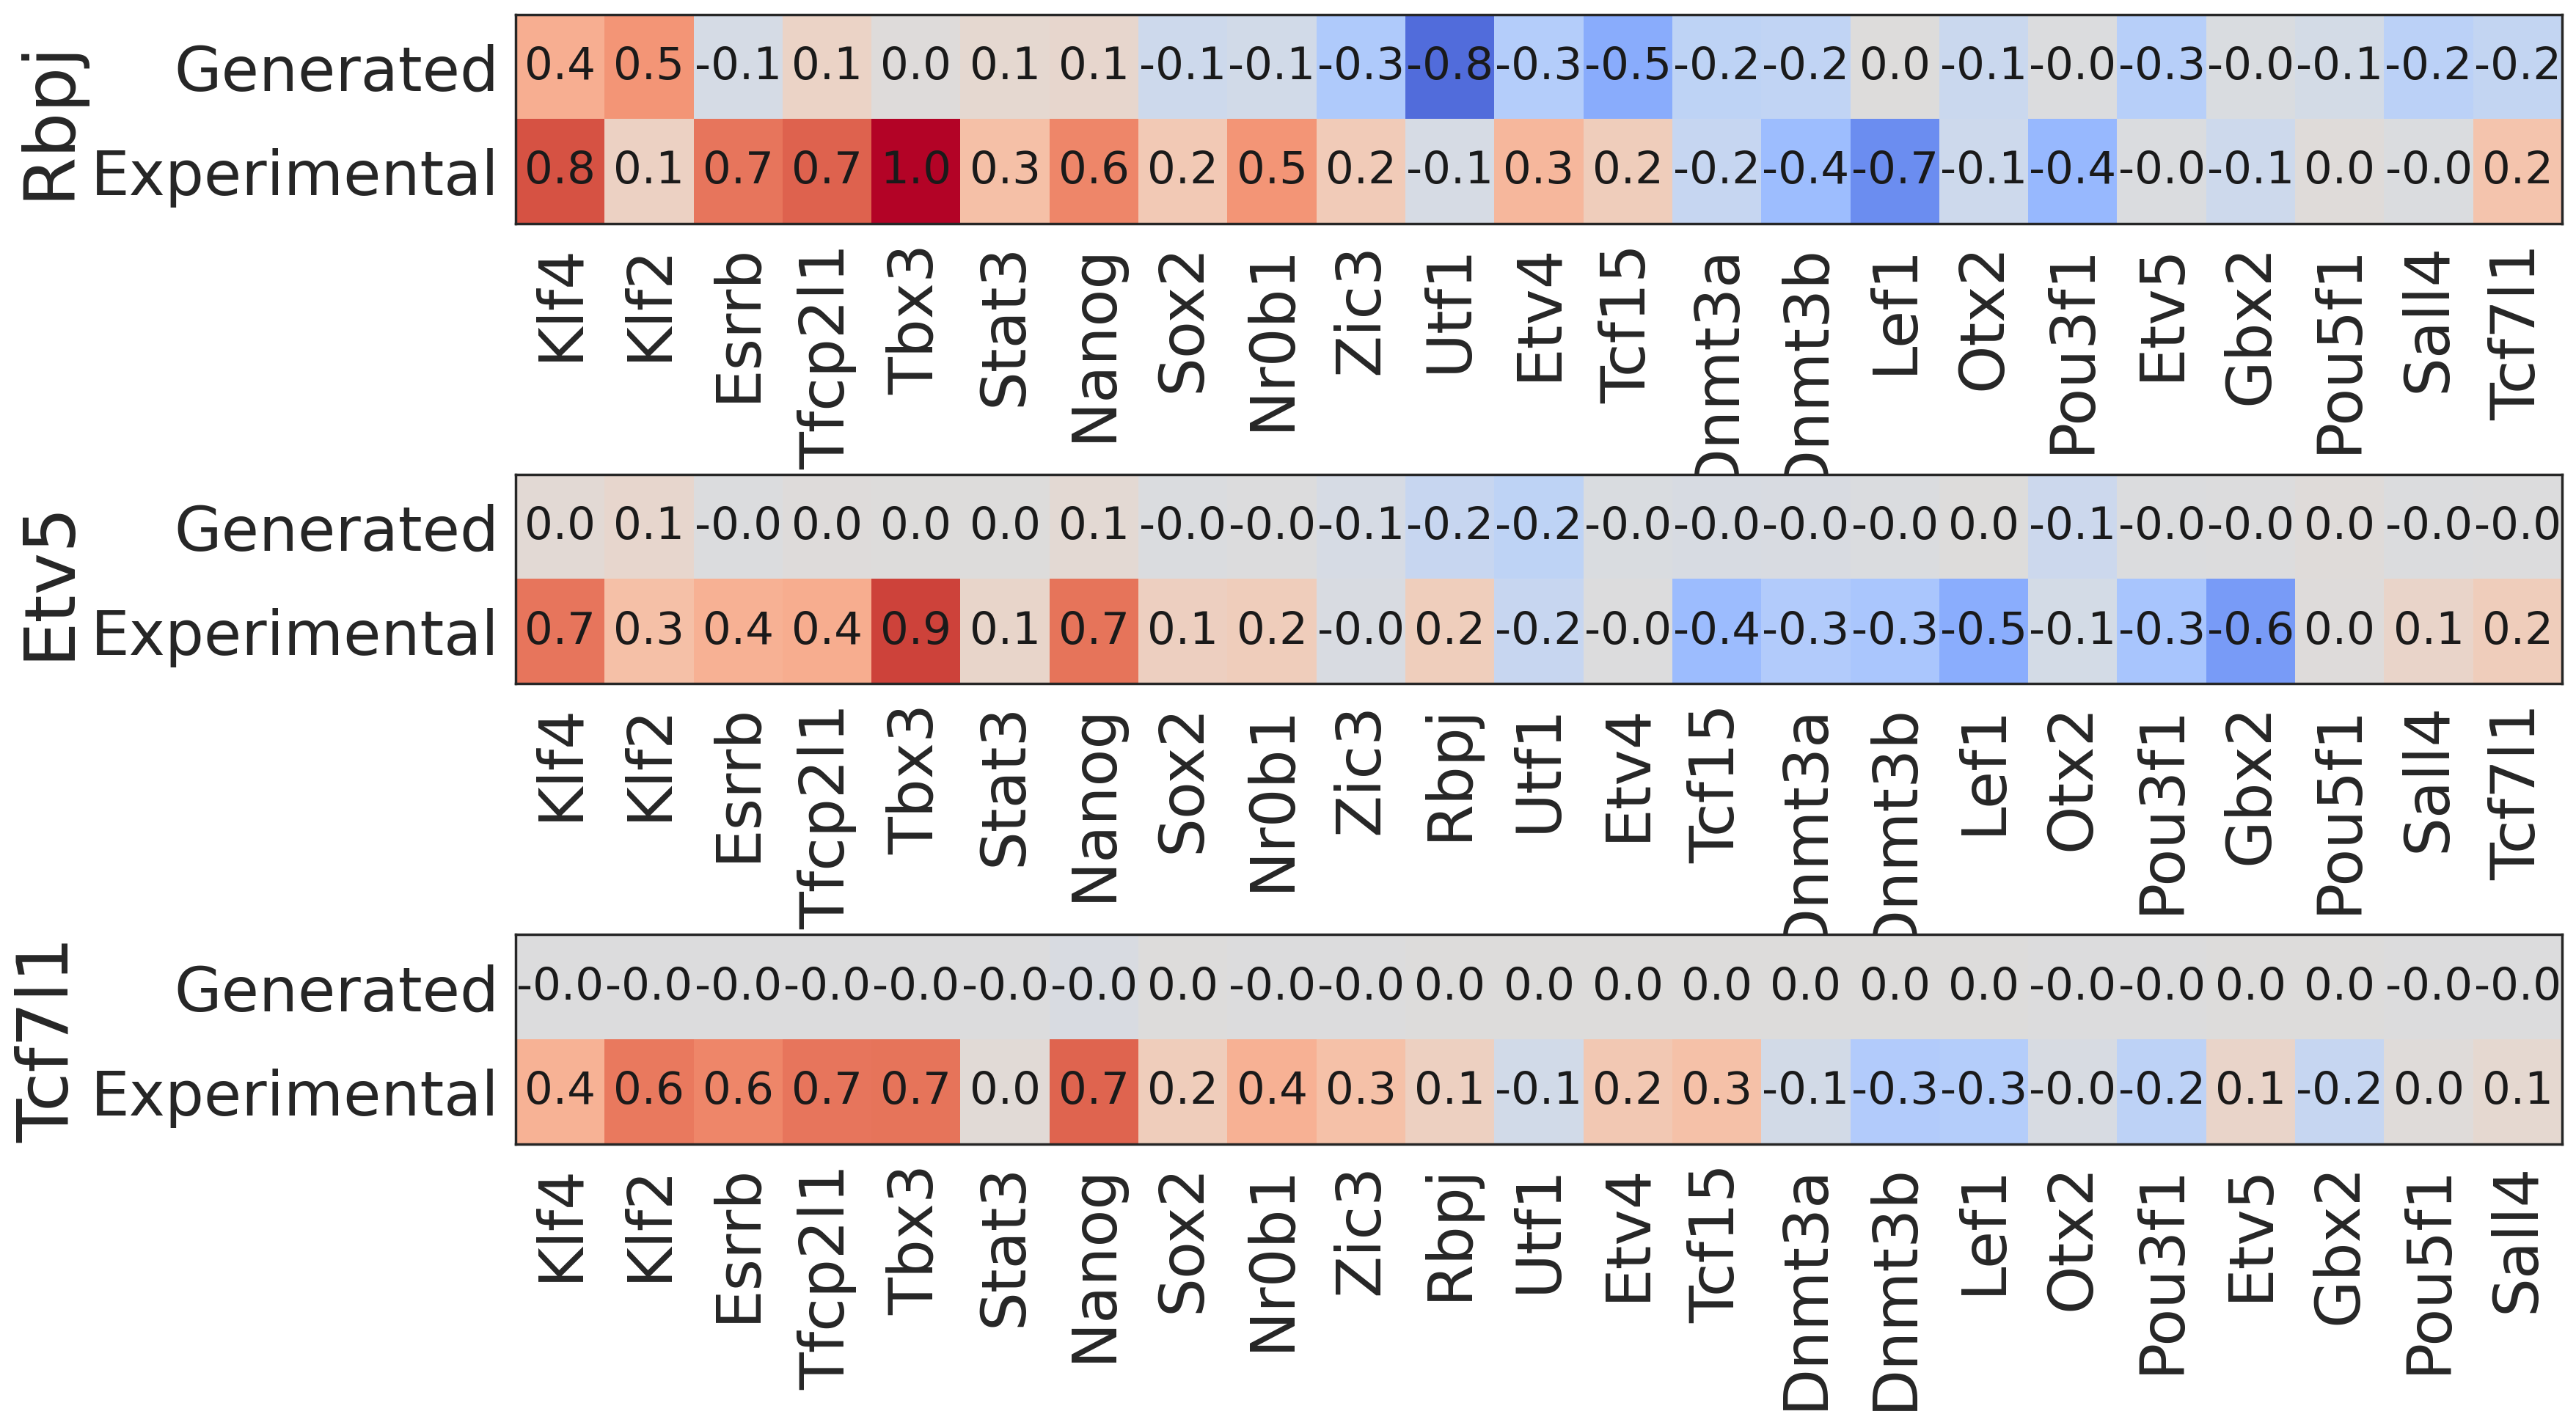

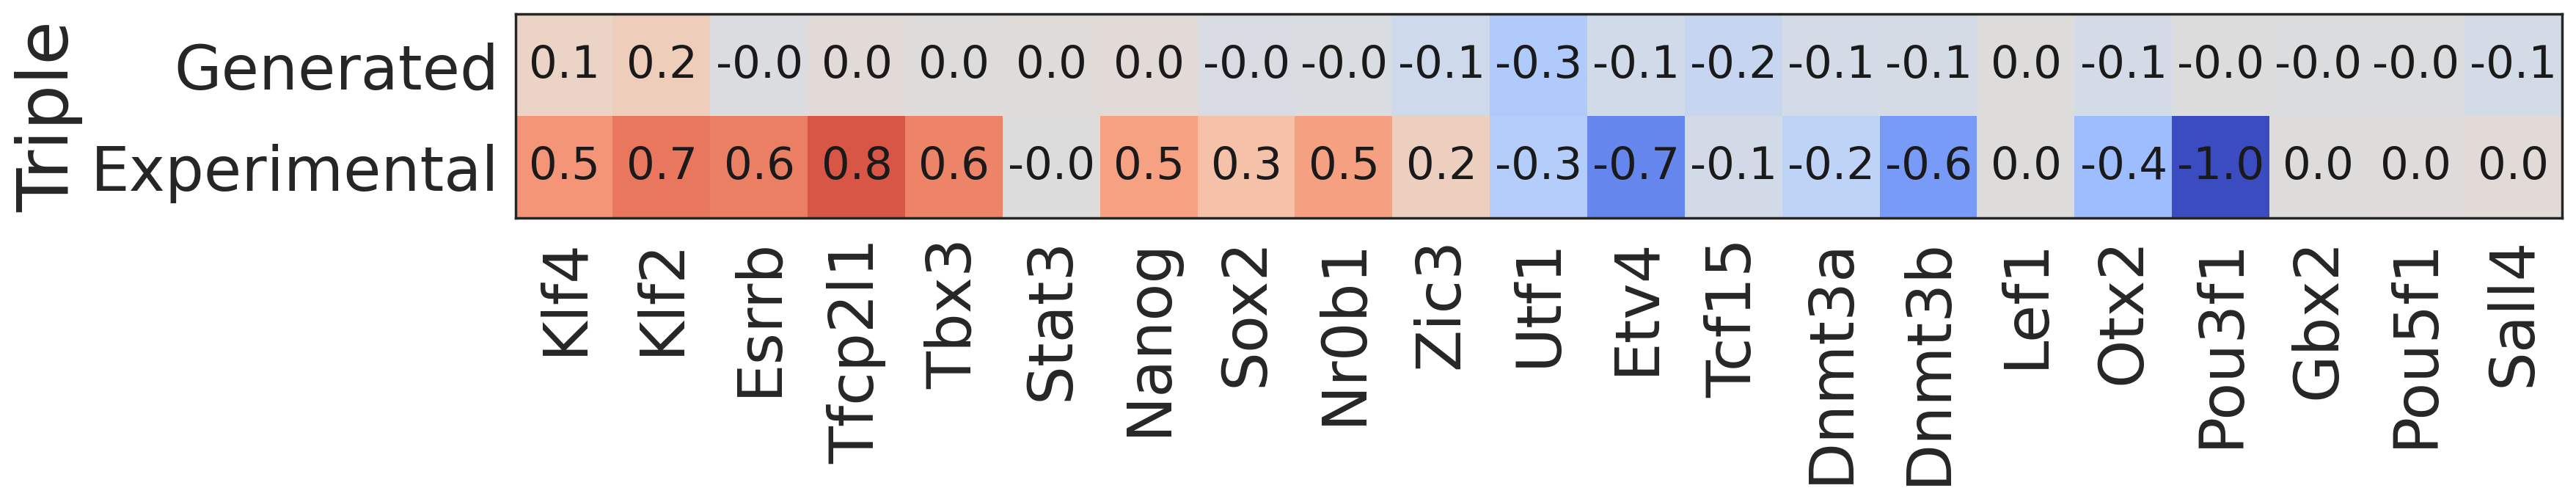

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(18,10), gridspec_kw={'height_ratios': [1,1,1]})
fko.KO_heat_comparison_T(diff_sim_norm[0,:], log2FC_exp_norm[0,:], "Rbpj", genes_KOs[0,:], fig, ax[0], Norm=False)
fko.KO_heat_comparison_T(diff_sim_norm[1,:], log2FC_exp_norm[1,:], "Etv5", genes_KOs[1,:], fig, ax[1], Norm=False)
fko.KO_heat_comparison_T(diff_sim_norm[2,:], log2FC_exp_norm[2,:], "Tcf7l1", genes_KOs[2,:], fig, ax[2], Norm=False)
plt.subplots_adjust(hspace=1.2)
# save the figure as svg
fig.savefig('single_KO_heatmap_CellOracle.svg', format='svg', bbox_inches='tight',  transparent=True,)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(18,1.8), gridspec_kw={'height_ratios': [1]})
fko.KO_heat_comparison_T(diff_triple, np.array(df_tKO_Kalkan_norm).squeeze(), "Triple", np.array(KO_genes_reference),fig, ax,  Norm=False)
fig.savefig('triple_KO_heatmap_CellOracle.svg', format='svg', bbox_inches='tight', transparent=True)

plt.show()

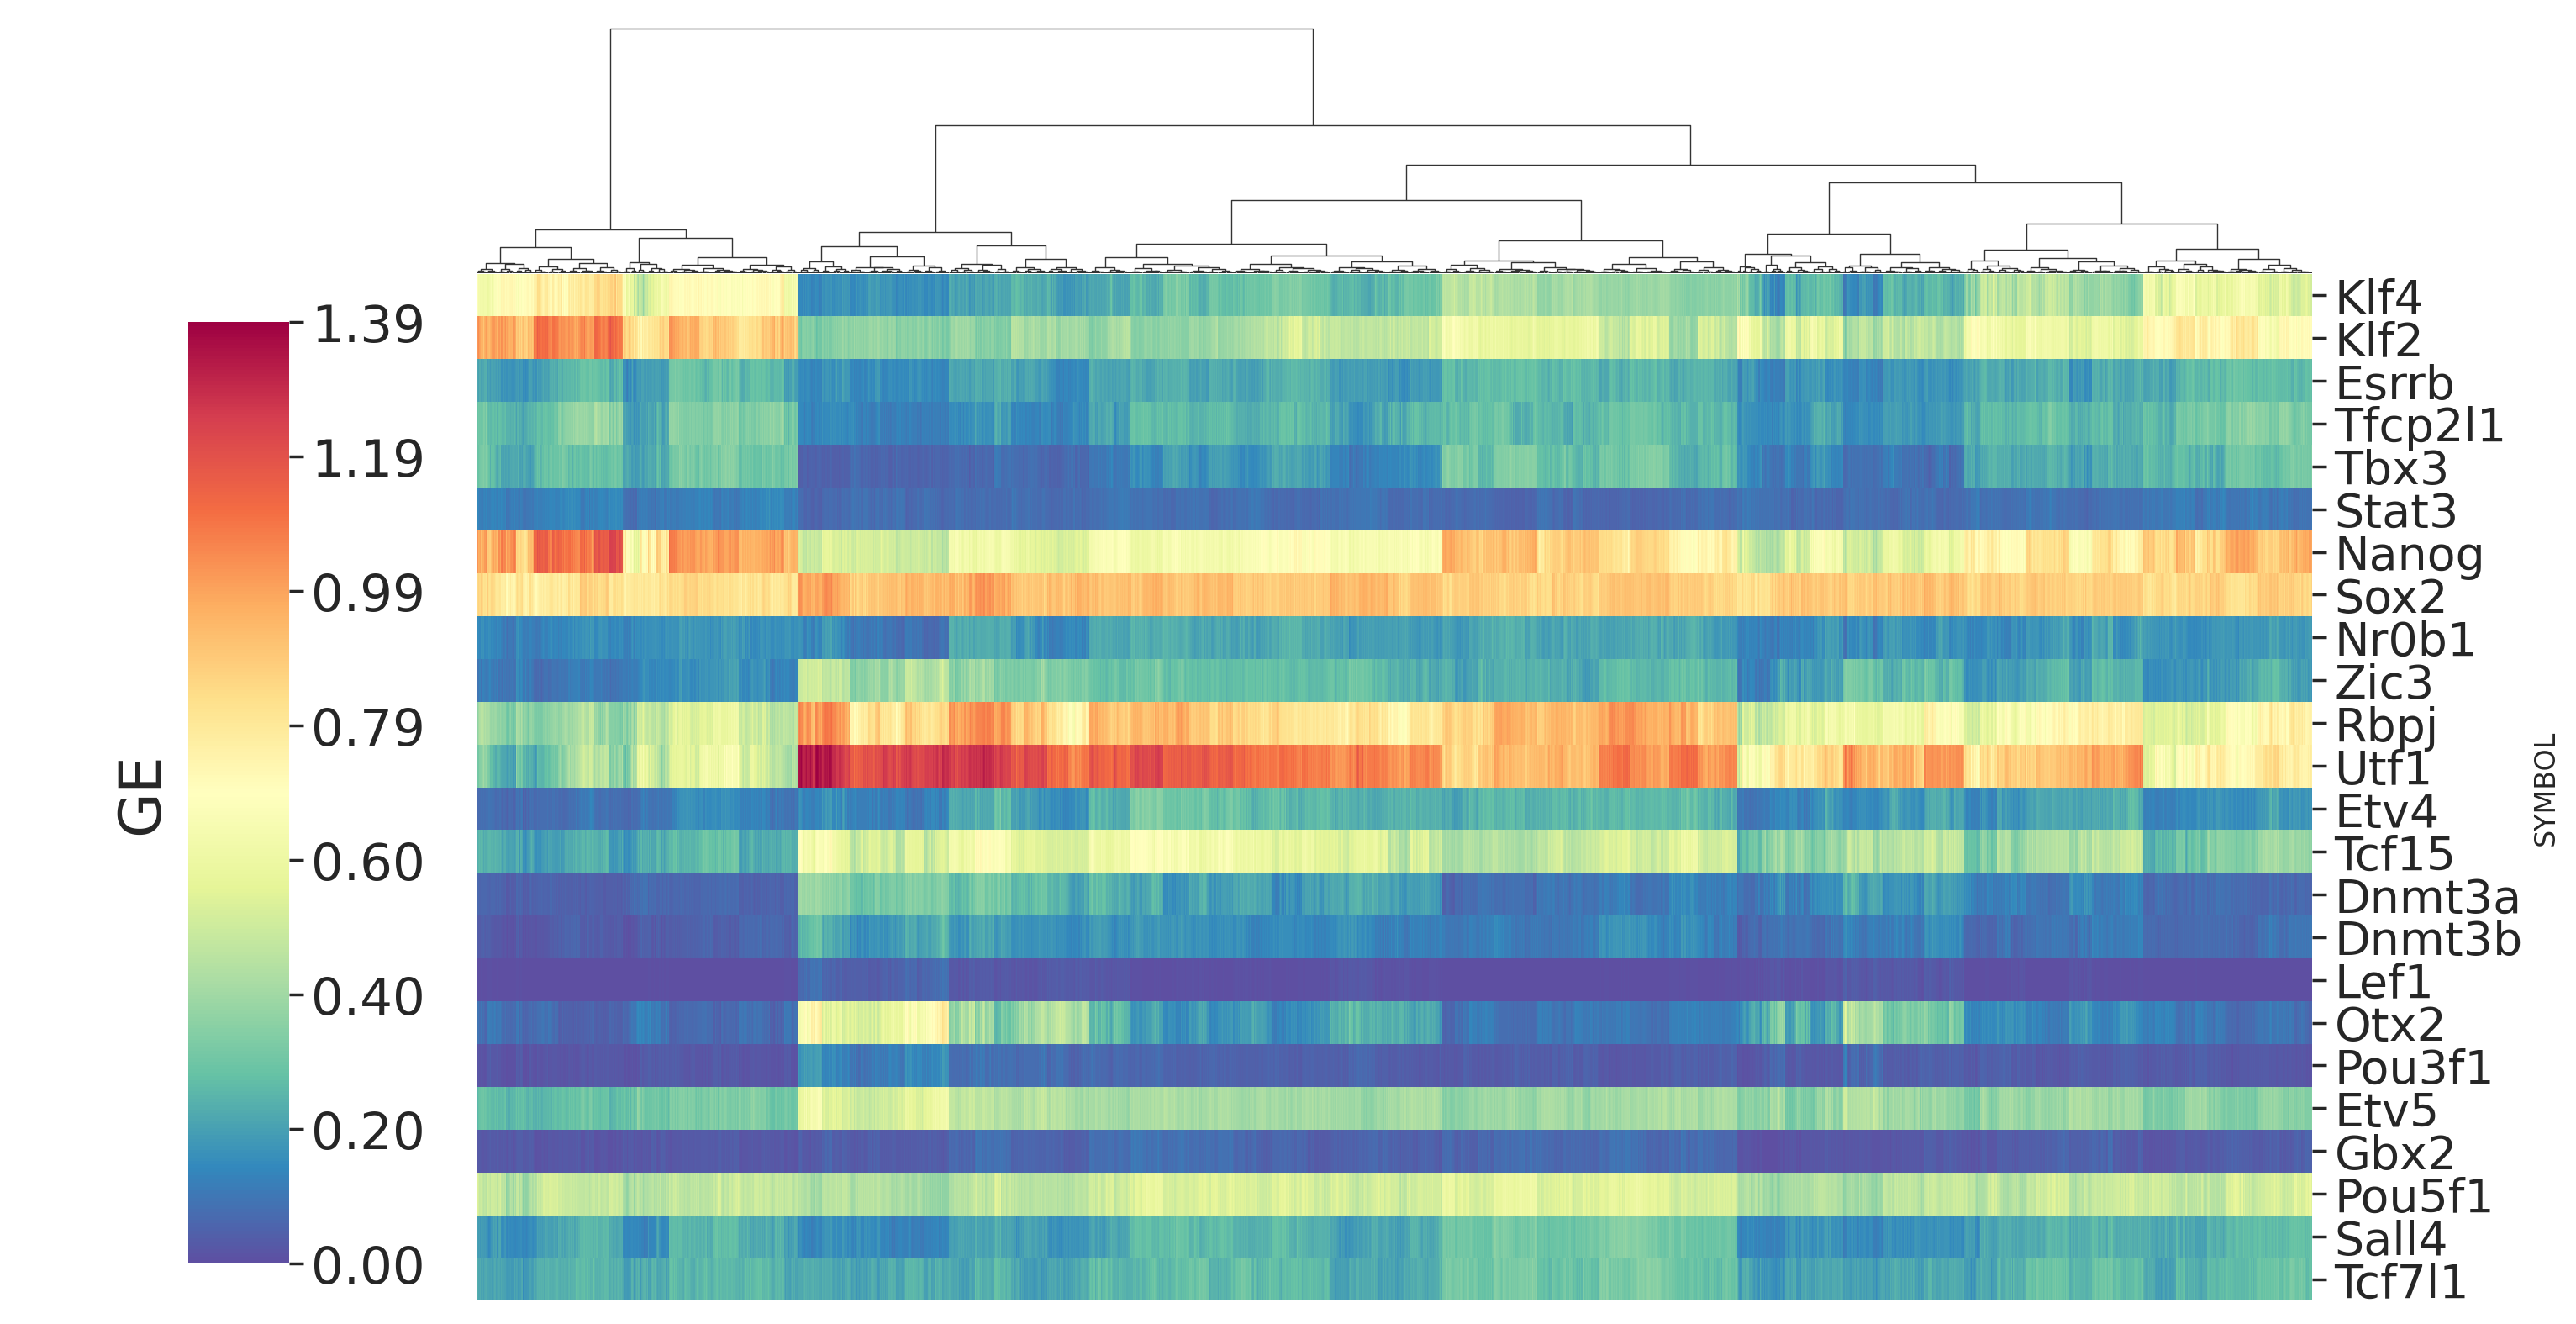

In [44]:
from scipy.cluster.hierarchy import linkage
import matplotlib.ticker as ticker
# Perform linkage on your numpy array
Z = linkage(df_wt_input_rel_genes, method='ward')

# Create a custom colorbar with more ticks
max_value = df_wt_input_rel_genes.max().max()
cbar_kws = {"ticks": np.linspace(0, max_value, num=8), "label": "GE"}

# Plot the dendrogram and heatmap with custom colorbar
g = sns.clustermap(df_wt_input_rel_genes.T, col_linkage=Z, cmap='Spectral_r', yticklabels=genes_list,
                   cbar=True, cbar_kws=cbar_kws, figsize=(15, 8), row_cluster=False, xticklabels=False)

# Adjust the colorbar size to match the heatmap
g.cax.set_position([.08, .05, .04, .7])

# Set the font size of the ticks for heatmap and colorbar
for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

for label in g.cax.get_yticklabels():
    label.set_size(22)
    
# set the font size of the colorbar label to 18
g.cax.yaxis.label.set_size(25)
g.cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
g.cax.yaxis.labelpad = 8
g.cax.yaxis.set_label_position('left')
# g.cax.yaxis.set_ticks_position('left')

plt.savefig('generated_wt_input_Celloracle_data_clustering.tiff', format='tiff', transparent=True, bbox_inches='tight')

plt.show()


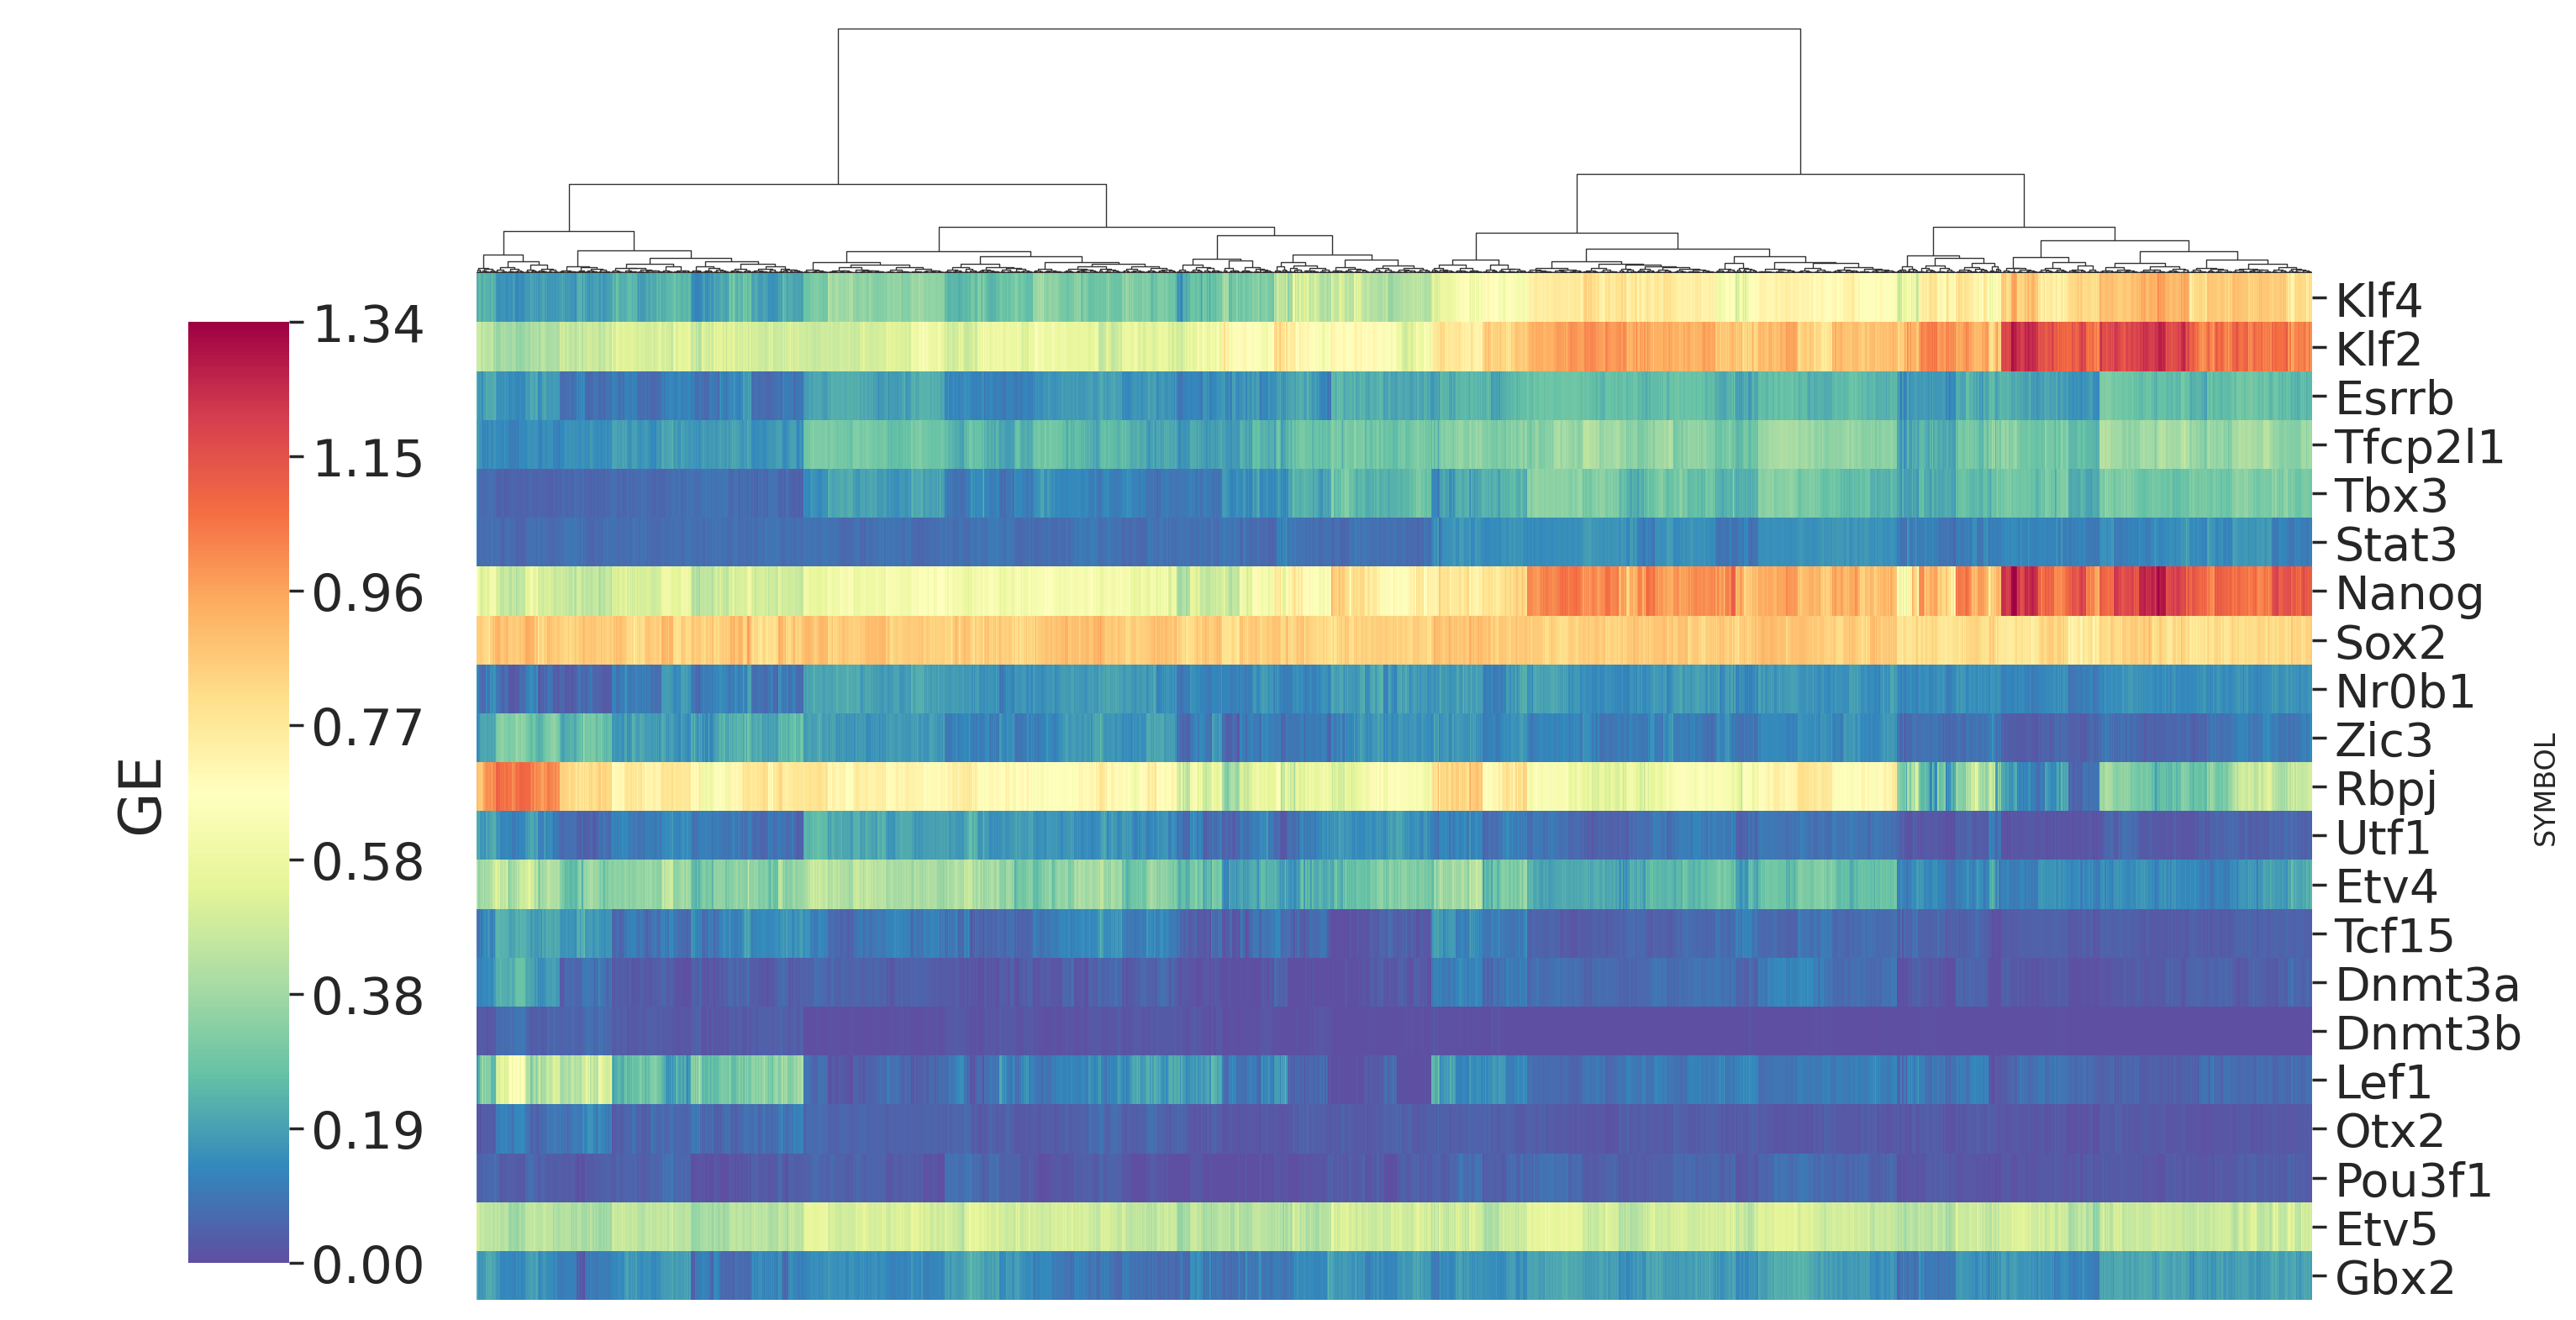

In [45]:
from scipy.cluster.hierarchy import linkage
import matplotlib.ticker as ticker
# Perform linkage on your numpy array
Z = linkage(df_simulated_imp_genes, method='ward')

# Create a custom colorbar with more ticks
max_value = df_simulated_imp_genes.max().max()
cbar_kws = {"ticks": np.linspace(0, max_value, num=8), "label": "GE"}

# Plot the dendrogram and heatmap with custom colorbar
g = sns.clustermap(df_simulated_imp_genes.T, col_linkage=Z, cmap='Spectral_r', yticklabels=genes_list,
                   cbar=True, cbar_kws=cbar_kws, figsize=(15, 8), row_cluster=False, xticklabels=False)

# Adjust the colorbar size to match the heatmap
g.cax.set_position([.08, .05, .04, .7])

# Set the font size of the ticks for heatmap and colorbar
for label in g.ax_heatmap.get_yticklabels():
    label.set_size(20)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0)

for label in g.cax.get_yticklabels():
    label.set_size(22)
    
# set the font size of the colorbar label to 18
g.cax.yaxis.label.set_size(25)
g.cax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
g.cax.yaxis.labelpad = 8
g.cax.yaxis.set_label_position('left')
# g.cax.yaxis.set_ticks_position('left')

plt.savefig('generated_tripleKO_generated_Celloracle_data_clustering.tiff', format='tiff', transparent=True, bbox_inches='tight')

plt.show()


In [46]:
KO_gene_idk = np.where(np.array(genes_df)==gene_KO)[0]

In [47]:
df_lN_mb_pst_reduced = np.delete(np.array(df_wt_input_rel_genes), KO_gene_idk, axis=1)
df_lN_mb_pst_reduced.shape

(9696, 21)

In [48]:
from sklearn.decomposition import PCA
pca_reduced = PCA(n_components=2)
pca_reduced.fit(df_lN_mb_pst_reduced)

principalComponents_reduced_full = pca_reduced.transform(df_lN_mb_pst_reduced)
KO_T_transformed = pca_reduced.transform(df_simulated_imp_genes)

principalComponents_reduced_full[:,0] = -principalComponents_reduced_full[:,0]
KO_T_transformed[:,0] = -KO_T_transformed[:,0]

principalDf_full_reduced = pd.DataFrame(data=principalComponents_reduced_full, columns=['PC1', 'PC2'])
KO_T_pca_df = pd.DataFrame(data=KO_T_transformed, columns=['PC1', 'PC2'])

In [49]:
# saving data to analyse them
df_wt_input_rel_genes.to_csv('df_wt_input_rel_genes.csv', index=False)
df_simulated_imp_genes.to_csv('df_triple_KO_input_rel_genes.csv', index=False)

print(df_wt_input_rel_genes.shape, df_simulated_imp_genes.shape)

(9696, 24) (9696, 21)


### Additional Plots

findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.
findfont: Font family 'Avenir' not found.


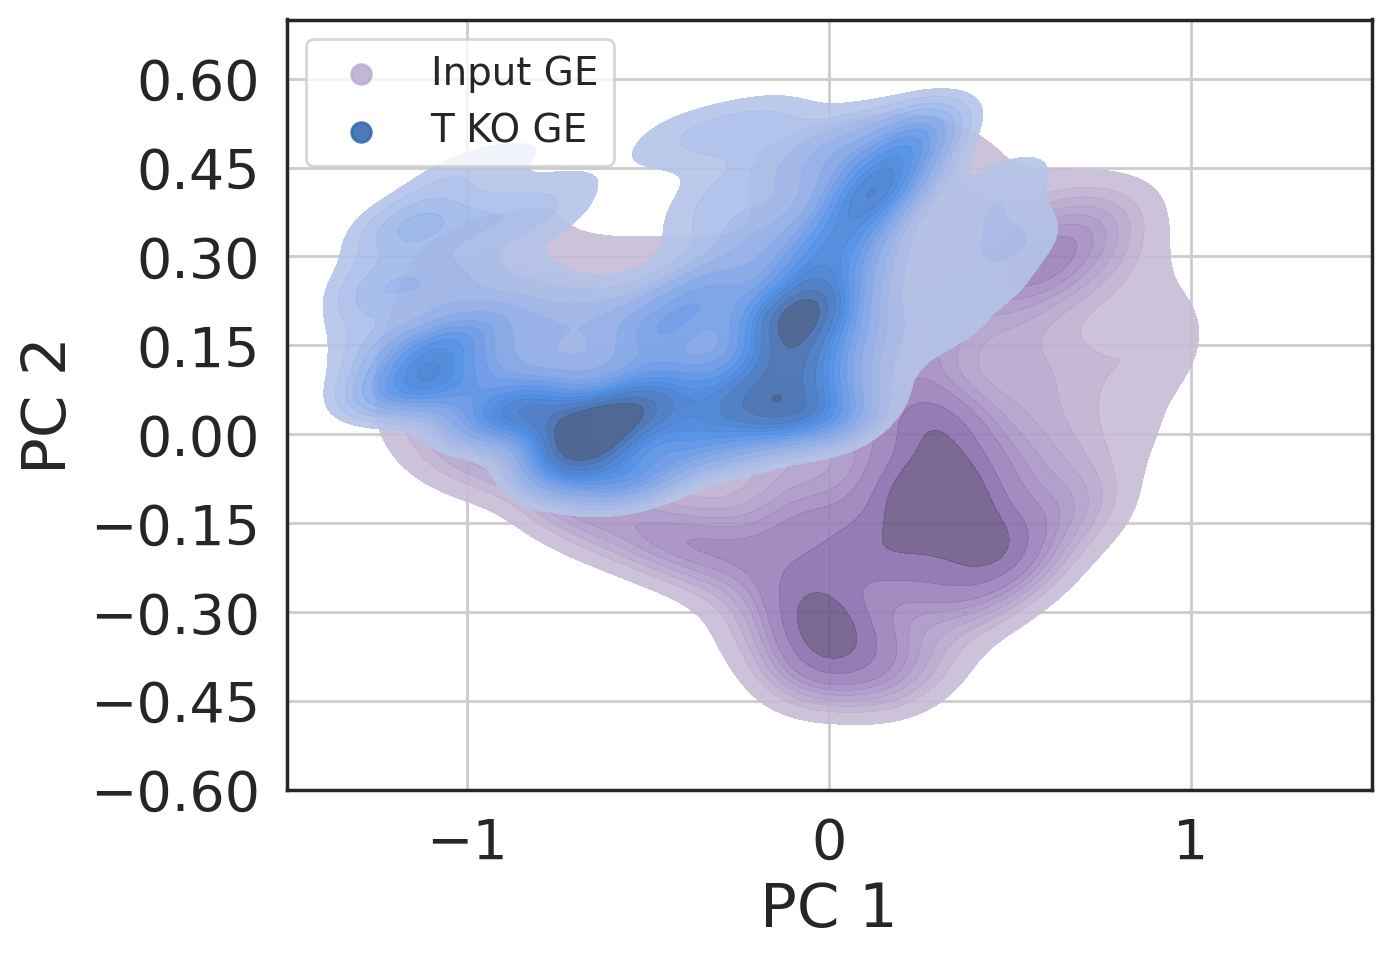

In [50]:
pca_input = PCA(n_components=2)
pca_input.fit(df_wt_input_rel_genes)

input_transformed = pca_input.transform(df_wt_input_rel_genes)
input_transformed[:,0] = -input_transformed[:,0]

principalDf_input = pd.DataFrame(data=input_transformed, columns=['PC1', 'PC2'])

# Plotting
plt.figure(figsize=(7,5))
font = {'family': 'Avenir', 'size': 22}
accent_palette = plt.cm.Accent
colors = ["darkgray", "royalblue", "indianred"]
colors = accent_palette([1, 2, 4])

sns.kdeplot(data=principalDf_input, x='PC1', y='PC2', levels=10, color=colors[0], linewidths=1.5, alpha=0.9, fill = True, bw_adjust=0.9)
sns.kdeplot(data=KO_T_pca_df, x='PC1', y='PC2', levels=15, color=colors[2], linewidths=1.5, alpha=0.9, fill = True, bw_adjust=0.9)

plt.scatter([],[], color=colors[0], s=50, label='Input GE', alpha=0.9)
plt.scatter([],[],  color=colors[2], s=50, label='T KO GE', alpha=0.9)
plt.legend(prop={'size': 14, 'family': 'Avenir'}, loc='upper center')
plt.xlabel('PC 1', fontdict=font)
plt.ylabel('PC 2', fontdict=font)
plt.xticks(fontsize=20)#, fontname='Avenir')
plt.yticks(fontsize=20)#, fontname='Avenir')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.xlim([-1.5,1.5])
plt.ylim([-.6,.7])
plt.grid(which='both')

plt.legend(loc='upper left', fontsize=14)

# Mostra il grafico
plt.savefig('PCA_Celloracle_wt_ko_GE.svg', format="svg", transparent = True, bbox_inches= 'tight')
plt.show()
